## Setup

In [ ]:
!pip install arch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import random
import math
import pickle
import yfinance as yf
import glob
from typing import Tuple
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')
from functorch import make_functional_with_buffers, vmap
from arch import arch_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/Undergrad Thesis/Deep Agent-Based Model/data"
df_paths = glob.glob(f"{data_dir}/*2m*")
dfs = []
for path in df_paths:
    with open(path, "rb") as f:
        dfs.append(pickle.load(f))

## Module

In [ ]:
#@title ABM Simulator Library
class Agent(nn.Module):
    def __init__(self, seq_dim, fund_dim, num_strategies):
        super().__init__()
        self.seq_dim = seq_dim
        self.fund_dim = fund_dim
        self.input_dim = seq_dim + fund_dim
        self.num_strategies = num_strategies

        self.technical = Technical(seq_dim)
        self.fundmental = Fundamental(fund_dim)
        self.policy = Policy(self.input_dim, num_strategies)

    def forward(self, x, z): # (B, O), (B,)
        chart = self.technical(x) # (B,)
        fund = self.fundmental(x, z) # (B,)
        vals = torch.stack([chart, fund], dim=-1) # (B, 2)
        policy = self.policy(x, z) # (B, num_strategies)
        choice = vals * policy # (B, num_strategies)
        decision = choice.sum(dim=-1) # (B,)
        return decision


class Technical(nn.Module):
    def __init__(self, seq_dim):
        super().__init__()
        self.tech_net = nn.Sequential(
            nn.Linear(seq_dim-1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.momentum = nn.Parameter(torch.randn(1))

    def forward(self, x): # (B, O)
        p_t = x[..., -1:] # (B,)
        p_h = x[..., :-1] # (B, O-1)
        ref = self.tech_net(p_h)
        pred = self.momentum * (p_t - ref)
        return pred.squeeze(-1)


class Fundamental(nn.Module):
    def __init__(self, fund_dim):
        super().__init__()
        self.revert = nn.Parameter(torch.randn(1))
        self.valuation_net = nn.Sequential(
            nn.Linear(fund_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, z): # (B, O), (B,)
        p_t = x[..., -1:] # (B,)
        v = self.valuation_net(z) # (B,1)
        revert = F.softplus(self.revert)
        pred = revert * (v - p_t)
        return pred.squeeze(-1)

class Policy(nn.Module):
    def __init__(self, input_dim, num_strategies):
        super().__init__()
        self.input_dim = input_dim
        self.num_strategies = num_strategies

        self.policy_net = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, num_strategies)
        )

    def forward(self, x, z): # (B, O)
        info = torch.cat([x, z], dim=-1) # (B, O+1)
        policy = self.policy_net(info) # (B, num_strategies)
        policy = F.gumbel_softmax(policy, dim=-1, hard=True, tau=1.0)
        return policy


class KyleImpact(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(0.01))   # learnable impact
        self.mu = nn.Parameter(torch.tensor(0.0))

    def forward(self, orders, x, z): # (B, N)
        prev_price = x[..., -1] # (B,)
        imbalance = orders.mean(-1) # (B,)
        price = self.mu + self.alpha * imbalance # (B,)
        return price


class ABM(nn.Module):
    def __init__(self, seq_dim, fund_dim, mu, sigma, n_agents=30, n_strategies=2):
        super().__init__()
        self.seq_dim = seq_dim
        self.fund_dim = fund_dim
        self.input_dim = seq_dim + fund_dim
        self.n_agents = n_agents
        self.n_strategies = n_strategies
        self.mu = mu
        self.sigma = sigma

        self.agents = nn.ModuleList([Agent(seq_dim, fund_dim, n_strategies) for _ in range(n_agents)])
        self.price_update = KyleImpact()

        self.input = None
        self.price_level = None

    def forward(self, steps, x, z_feat, price_level):
        if len(x.shape) == 1:
            x = x.unsqueeze(0) # (B, O)
        if len(z_feat.shape) == 1:
            z_feat = z_feat.unsqueeze(0) # (B, F)
        if len(price_level.shape) == 0:
            price_level = price_level.unsqueeze(0) # (B,)
        self.input = x # (B, O)
        self.price_level = price_level # (B,)
        B = x.size(0)
        seq = []
        for t in range(steps):
            z_t = self.update_fund(self.input, z_feat, t)
            p = self.step(self.input, z_t) # (B, 1)
            p = p.squeeze(-1) # (B,)
            self.update_input(p)
            seq.append(p)
        return torch.stack(seq, dim=-1) # (B, T)

    def step(self, x, z): # (B, O)
        orders = self.agent_decision(x, z) # (B, N)
        _, price = self.price_formation(orders, x, z) # (B, 1)
        return price

    def agent_decision(self, x, z):
        decisions = [agent(x, z) for agent in self.agents] # [(B,)]*N
        orders = torch.stack(decisions, dim=-1) # (B, N)
        return orders    # (B,N)

    def price_formation(self, orders, x, z):
        price = self.price_update(orders, x, z) # (B,)
        return orders, price

    def update_input(self, price): # (B,)
        with torch.no_grad():
            self.input = torch.roll(self.input, shifts=-1, dims=-1) # (B, O-1)
            self.input[..., -1] = price # (B, O)

    def update_fund(self, x, z_feat, t):
        B = x.size(0)
        if z_feat.dim() == 1 or z_feat.size(0) == 1:   # (6,) or (1,6) → (B,6)
            z_feat = z_feat.expand(B, -1)

        if t > 0:
            normalized_return = x[:, -1]
            actual_return = normalized_return * self.sigma + self.mu
            price_ratio = torch.exp(actual_return)
            self.price_level = self.price_level * price_ratio

        p_t = self.price_level            # (B,)
        shares, net_inc, fcf, cse = z_feat[:,0], z_feat[:,3], z_feat[:,4], z_feat[:,5]

        mcap = p_t * shares + 1e-8 # (B,)

        epr  = net_inc / mcap      # (B,)
        bmr  = cse     / mcap      # (B,)
        cfpr = fcf     / mcap      # (B,)

        return torch.stack([epr, bmr, cfpr], dim=1).float()   # (B,3)

    def compute_loss(self, preds, y, val_alpha=1.0, vol_beta=1.0, skew_gamma=1.0, kurt_lambda=1.0, kl_theta=1.0):
        if val_alpha != 0:
            loss_pred = F.mse_loss(preds, y)
        else:
            loss_pred = torch.tensor(0.0)

        if vol_beta != 0:
            var_pred = preds.std(dim=-1, unbiased=False)
            var_true = y.std(dim=-1, unbiased=False)
            loss_vol = F.mse_loss(var_pred, var_true)
        else:
            loss_vol = torch.tensor(0.0)

        if skew_gamma != 0:
            skew_pred = skewness(preds, dim=-1)
            skew_true = skewness(y, dim=-1)
            loss_skew = F.mse_loss(skew_pred, skew_true)
        else:
            loss_skew = torch.tensor(0.0)

        if kurt_lambda != 0:
            kurt_pred = kurtosis(preds, dim=-1)
            kurt_true = kurtosis(y, dim=-1)
            loss_kurt = F.mse_loss(kurt_pred, kurt_true)
        else:
            loss_kurt = torch.tensor(0.0)

        if kl_theta != 0:
            loss_kl = F.kl_div(preds, y, reduction='batchmean', log_target=True)
        else:
            loss_kl = torch.tensor(0.0)

        loss = val_alpha * loss_pred + vol_beta * loss_vol + skew_gamma * loss_skew + kurt_lambda * loss_kurt + kl_theta * loss_kl
        return loss, loss_pred, loss_vol, loss_skew, loss_kurt, loss_kl

    def simulate(self, x, z, price_level, steps: int = 10, seed: int = 42):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if z.dim() == 1:
            z = z.unsqueeze(0)

        torch.manual_seed(seed)
        self.input = x.clone()
        self.price_level = price_level.clone()

        logR, orders_all, policies_all = [], [], []

        with torch.no_grad():
            for t in range(steps):
                z_t = self.update_fund(self.input, z, t)

                decisions, policies = [], []
                for ag in self.agents:
                    state = torch.get_rng_state()
                    decisions.append(ag(self.input, z_t))
                    torch.set_rng_state(state)
                    policies.append(ag.policy(self.input, z_t))

                orders = torch.stack(decisions, dim=-1)  # (B,N)
                pols = torch.stack(policies, dim=-1).permute(0, 2, 1)  # (B,N,2)

                _, p = self.price_formation(orders, self.input, z_t)

                logR.append(p)
                orders_all.append(orders)
                policies_all.append(pols)

                self.update_input(p)

        # Stack tensors
        logR = torch.stack(logR, dim=-1)  # (B, T)
        orders_all = torch.stack(orders_all, dim=1)  # (B, T, N)
        policies_all = torch.stack(policies_all, dim=1)  # (B, T, N, 2)

        return {
            'log_returns': logR,
            'orders': orders_all,
            'policies': policies_all,
            'initial_price': price_level,
            'final_input': self.input,
            'final_price_level': self.price_level
        }

    def visualize_simulation(self, sim_results, y=None, n_agents=None):
        # Extract data
        logR = sim_results['log_returns'].squeeze(0).cpu().numpy()
        orders = sim_results['orders'].squeeze(0).cpu().numpy()  # (T, N)
        policies = sim_results['policies'].squeeze(0).cpu().numpy()  # (T, N, 2)

        steps = len(logR)
        if n_agents is None:
            n_agents = orders.shape[1]

        # Process data for visualization
        B_mat = np.array([np.where(o > 0, o, np.nan) for o in orders])
        A_mat = np.array([np.where(o < 0, o, np.nan) for o in orders])
        chart_ratio = policies[:, :, 0].mean(axis=1)
        fund_ratio = policies[:, :, 1].mean(axis=1)

        # Color scheme
        bid_c, ask_c = "blue", "red"
        chart_c, fund_c = "#2ca02c", "#9467bd"

        # Main figure
        fig, (ax1, axm, axp) = plt.subplots(
            3, 1, figsize=(16, 10),
            gridspec_kw={"height_ratios": [1, 2, 1]}
        )

        # (i) Log return
        ax1.plot(np.arange(steps), logR, label="model")
        if y is not None:
            y_log = y.squeeze().cpu().numpy()[:steps]
            ax1.plot(np.arange(steps), y_log, color='orange',
                    linewidth=2, label="ground truth")
        ax1.set_title("Log Return")
        ax1.set_ylabel("log ΔP")
        ax1.set_xlabel("Step")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # (ii) Order flow
        t_idx = np.repeat(np.arange(steps)[:, None], n_agents, axis=1)
        axm.scatter(t_idx.flatten(), B_mat.flatten(), c=bid_c, s=6, alpha=0.6, label="Bid")
        axm.scatter(t_idx.flatten(), A_mat.flatten(), c=ask_c, s=6, alpha=0.6, label="Ask")
        axm.axhline(0, color="black", lw=0.8)
        axm.set_xlim(-0.5, steps - 0.5)
        axm.set_xlabel("Step")
        axm.set_ylabel("Order Size")
        axm.set_title("Order Flow")
        axm.legend(loc="upper right")
        axm.grid(True, alpha=0.3)

        # (iii) Strategy mix
        axp.plot(np.arange(steps), chart_ratio, color=chart_c, label="Chartist", linewidth=2)
        axp.plot(np.arange(steps), fund_ratio, color=fund_c, label="Fundamentalist", linewidth=2)
        axp.set_ylim(0, 1)
        axp.set_xlabel("Step")
        axp.set_ylabel("Average Weight")
        axp.set_title("Strategy Mix")
        axp.legend(loc="upper right")
        axp.grid(True, alpha=0.3)

        plt.tight_layout()

        # Regime shading figure
        fig_rs, ax_rs = plt.subplots(figsize=(16, 3))
        ax_rs.plot(np.arange(steps), logR, color="black", lw=1)
        ax_rs.set_title("Log Return with Regime Shading")
        ax_rs.set_ylabel("log ΔP")

        lime = np.array(mcolors.to_rgb("#32ff32"))
        mag = np.array(mcolors.to_rgb("#ff32ff"))

        for t in range(steps):
            fr = fund_ratio[t]
            cr = chart_ratio[t]
            tot = fr + cr
            if tot > 0:
                fr = fr / tot
                cr = cr / tot
                bg = cr * lime + fr * mag
                bg = np.clip(bg, 0, 1)
                ax_rs.axvspan(t - 0.5, t + 0.5, color=bg, alpha=0.35)

        ax_rs.set_xlim(-0.5, steps - 0.5)
        ax_rs.set_xlabel("Step")
        ax_rs.grid(True, alpha=0.3)
        plt.tight_layout()

        # Cumulative price figure
        price_model = np.cumprod(np.insert(np.exp(logR), 0, 1.0))
        fig_cp, ax_cp = plt.subplots(figsize=(10, 3))
        ax_cp.plot(np.arange(steps + 1), price_model, label="Model")

        if y is not None:
            price_true = np.cumprod(np.insert(np.exp(y_log), 0, 1.0))
            ax_cp.plot(np.arange(steps + 1), price_true, color='orange',
                      lw=2, label="Ground Truth")

        ax_cp.set_title("Cumulative Price (Log-scale)")
        ax_cp.set_xlabel("Step")
        ax_cp.set_ylabel("Price Level")
        ax_cp.set_yscale('log')
        ax_cp.legend()
        ax_cp.grid(True, alpha=0.3)
        plt.tight_layout()

        plt.show()

    def evaluate(self, dataset, sim_steps, n_samples, device='cuda', batch_size=32,
            eval_fat_tails=True, eval_vol_clustering=True, eval_long_memory=True,
            max_lag=60, seed=42):
        self.to(device)
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Validate minimum computational requirements
        if eval_fat_tails and sim_steps < 4:
            raise ValueError("Fat tail analysis requires at least 4 steps for kurtosis computation")
        if eval_vol_clustering and sim_steps < max_lag + 1:
            raise ValueError(f"Volatility clustering with max_lag={max_lag} requires at least {max_lag+1} steps")
        if eval_long_memory and sim_steps < 4:
            raise ValueError("Long memory analysis requires at least 4 steps")

        # Storage for results
        results = {
            'sim_returns': [],
            'gt_returns': [],
            'fat_tails': {},
            'vol_clustering': {},
            'long_memory': {}
        }

        # Create data loader
        sampler = torch.utils.data.RandomSampler(dataset, num_samples=n_samples, replacement=True)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

        print(f"Evaluating {n_samples} samples with {sim_steps} steps each...")

        # Collect all simulated and ground truth returns
        all_sim_returns = []
        all_gt_returns = []

        with torch.no_grad():
            for batch_idx, (x, y, init_price) in enumerate(loader):
                x = x.to(device)
                init_price = init_price.to(device)
                z = dataset.feats.to(device).unsqueeze(0).expand(x.size(0), -1)

                # Run batch simulation
                sim_results = []
                for i in range(x.size(0)):
                    result = self.simulate(x[i], z[i], init_price[i], steps=sim_steps, seed=seed+batch_idx*1000+i)
                    sim_results.append(result['log_returns'])

                # Fix: squeeze to get correct shape
                batch_sim = torch.stack(sim_results).squeeze(1).cpu().numpy()  # (B, sim_steps)
                all_sim_returns.append(batch_sim)

                # Collect ground truth
                batch_gt = []
                for i in range(x.size(0)):
                    dataset_idx = batch_idx * batch_size + i
                    if dataset_idx < len(dataset):
                        start_idx = dataset_idx + dataset.past
                        end_idx = min(start_idx + sim_steps, len(dataset.series))
                        if end_idx > start_idx:
                            gt_segment = dataset.series[start_idx:end_idx].numpy()
                            if len(gt_segment) < sim_steps:
                                gt_segment = np.pad(gt_segment, (0, sim_steps - len(gt_segment)),
                                                  mode='constant', constant_values=np.nan)
                            batch_gt.append(gt_segment)

                if batch_gt:
                    all_gt_returns.append(np.array(batch_gt))

        # Concatenate all results
        all_sim_returns = np.concatenate(all_sim_returns, axis=0)
        if all_gt_returns:
            all_gt_returns = np.concatenate(all_gt_returns, axis=0)
            valid_gt_mask = np.sum(~np.isnan(all_gt_returns), axis=1) >= sim_steps * 0.8
            all_gt_returns = all_gt_returns[valid_gt_mask]

        results['sim_returns'] = all_sim_returns
        results['gt_returns'] = all_gt_returns

        print(f"\nCollected {len(all_sim_returns)} simulated samples")
        print(f"Collected {len(all_gt_returns)} ground truth samples")

        # 1. FAT TAILS ANALYSIS
        if eval_fat_tails:
            print("\n" + "="*60)
            print("ANALYZING FAT TAILS...")
            print("="*60)
            results['fat_tails'] = self._analyze_fat_tails(all_sim_returns, all_gt_returns)

        # 2. VOLATILITY CLUSTERING ANALYSIS
        if eval_vol_clustering:
            print("\n" + "="*60)
            print("ANALYZING VOLATILITY CLUSTERING...")
            print("="*60)
            results['vol_clustering'] = self._analyze_vol_clustering(all_sim_returns, all_gt_returns, max_lag)

        # 3. LONG MEMORY ANALYSIS
        if eval_long_memory:
            print("\n" + "="*60)
            print("ANALYZING LONG MEMORY...")
            print("="*60)
            results['long_memory'] = self._analyze_long_memory(all_sim_returns, all_gt_returns)

        self.to('cpu')
        return results
    def _analyze_fat_tails(self, sim_returns, gt_returns):
        results = {}

        # 1. Excess Kurtosis
        sim_excess_kurt = []
        gt_excess_kurt = []

        for i in range(len(sim_returns)):
            try:
                kurt = stats.kurtosis(sim_returns[i], fisher=True, nan_policy='omit')
                if not np.isnan(kurt) and not np.isinf(kurt):
                    sim_excess_kurt.append(float(kurt))  # Convert to Python float
            except:
                pass

        for i in range(len(gt_returns)):
            try:
                kurt = stats.kurtosis(gt_returns[i], fisher=True, nan_policy='omit')
                if not np.isnan(kurt) and not np.isinf(kurt):
                    gt_excess_kurt.append(float(kurt))  # Convert to Python float
            except:
                pass

        sim_excess_kurt = np.array(sim_excess_kurt, dtype=np.float64)
        gt_excess_kurt = np.array(gt_excess_kurt, dtype=np.float64)

        # Check if we have data
        if len(sim_excess_kurt) == 0 or len(gt_excess_kurt) == 0:
            print("WARNING: No valid kurtosis values computed.")
            results['sim_excess_kurt'] = sim_excess_kurt
            results['gt_excess_kurt'] = gt_excess_kurt
            return results

        # Plot histogram
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create bins
        all_kurt = np.concatenate([sim_excess_kurt, gt_excess_kurt])
        kurt_min, kurt_max = np.percentile(all_kurt, [1, 99])
        bins = np.linspace(kurt_min, kurt_max, 30)

        ax.hist(sim_excess_kurt, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_excess_kurt)})',
                density=True, color='blue')
        ax.hist(gt_excess_kurt, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_excess_kurt)})',
                density=True, color='orange')
        ax.axvline(0, color='red', linestyle='--', label='Normal (excess=0)')
        ax.set_xlabel('Excess Kurtosis')
        ax.set_ylabel('Density')
        ax.set_title('Distribution of Excess Kurtosis')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # Summary table
        print("\nExcess Kurtosis Statistics:")
        print("-" * 50)
        print(f"{'Metric':<20} {'Simulated':<15} {'Ground Truth':<15}")
        print("-" * 50)
        print(f"{'Count':<20} {len(sim_excess_kurt):<15} {len(gt_excess_kurt):<15}")
        print(f"{'Mean':<20} {np.mean(sim_excess_kurt):<15.4f} {np.mean(gt_excess_kurt):<15.4f}")
        print(f"{'Std':<20} {np.std(sim_excess_kurt):<15.4f} {np.std(gt_excess_kurt):<15.4f}")
        print(f"{'Median':<20} {np.median(sim_excess_kurt):<15.4f} {np.median(gt_excess_kurt):<15.4f}")
        print(f"{'25th percentile':<20} {np.percentile(sim_excess_kurt, 25):<15.4f} {np.percentile(gt_excess_kurt, 25):<15.4f}")
        print(f"{'75th percentile':<20} {np.percentile(sim_excess_kurt, 75):<15.4f} {np.percentile(gt_excess_kurt, 75):<15.4f}")

        results['sim_excess_kurt'] = sim_excess_kurt
        results['gt_excess_kurt'] = gt_excess_kurt

        # 2. Hill Estimator
        def hill_estimator(data, k):
            abs_data = np.abs(data)
            abs_data = abs_data[~np.isnan(abs_data)]
            if len(abs_data) < k + 1:
                return np.nan
            sorted_data = np.sort(abs_data)[::-1]
            if sorted_data[k] <= 0:
                return np.nan
            try:
                return float(k / np.sum(np.log(sorted_data[:k] / sorted_data[k])))
            except:
                return np.nan

        # Determine k values based on actual data length
        min_length = min([len(r[~np.isnan(r)]) for r in sim_returns] +
                        [len(r[~np.isnan(r)]) for r in gt_returns])
        max_k = min(50, max(5, min_length // 4))

        if max_k < 5:
            print(f"WARNING: Data too short for Hill estimator (min length: {min_length})")
            results['hill_k_values'] = []
            results['sim_hill_mean'] = []
            results['sim_hill_std'] = []
            results['gt_hill_mean'] = []
            results['gt_hill_std'] = []
        else:
            k_values = list(range(5, max_k + 1))

            sim_hill_all = []
            gt_hill_all = []

            for returns in sim_returns:
                hill_vals = [hill_estimator(returns, k) for k in k_values]
                if any(not np.isnan(v) for v in hill_vals):
                    sim_hill_all.append(hill_vals)

            for returns in gt_returns:
                hill_vals = [hill_estimator(returns, k) for k in k_values]
                if any(not np.isnan(v) for v in hill_vals):
                    gt_hill_all.append(hill_vals)

            if len(sim_hill_all) > 0 and len(gt_hill_all) > 0:
                sim_hill_all = np.array(sim_hill_all, dtype=np.float64)
                gt_hill_all = np.array(gt_hill_all, dtype=np.float64)

                # Plot Hill estimator
                fig, ax = plt.subplots(figsize=(12, 6))
                sim_mean = np.nanmean(sim_hill_all, axis=0)
                sim_std = np.nanstd(sim_hill_all, axis=0)
                gt_mean = np.nanmean(gt_hill_all, axis=0)
                gt_std = np.nanstd(gt_hill_all, axis=0)

                ax.plot(k_values, sim_mean, 'b-', label='Simulated', linewidth=2)
                ax.fill_between(k_values, sim_mean - sim_std, sim_mean + sim_std, alpha=0.3, color='blue')
                ax.plot(k_values, gt_mean, 'orange', label='Ground Truth', linewidth=2)
                ax.fill_between(k_values, gt_mean - gt_std, gt_mean + gt_std, alpha=0.3, color='orange')
                ax.axhline(y=2, color='red', linestyle='--', label='Normal (α=2)')
                ax.set_xlabel('k (number of order statistics)')
                ax.set_ylabel('Hill Estimate (α)')
                ax.set_title('Hill Estimator of Tail Index')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

                # Full Hill table
                print("\nHill Estimator Statistics (Mean ± Std):")
                print("-" * 60)
                print(f"{'k':<10} {'Simulated':<25} {'Ground Truth':<25}")
                print("-" * 60)
                for i, k in enumerate(k_values):
                    sim_str = f"{sim_mean[i]:.4f} ± {sim_std[i]:.4f}" if not np.isnan(sim_mean[i]) else "NaN"
                    gt_str = f"{gt_mean[i]:.4f} ± {gt_std[i]:.4f}" if not np.isnan(gt_mean[i]) else "NaN"
                    print(f"{k:<10} {sim_str:<25} {gt_str:<25}")

                results['hill_k_values'] = k_values
                results['sim_hill_mean'] = sim_mean
                results['sim_hill_std'] = sim_std
                results['gt_hill_mean'] = gt_mean
                results['gt_hill_std'] = gt_std
            else:
                print("WARNING: No valid Hill estimator values computed")
                results['hill_k_values'] = k_values
                results['sim_hill_mean'] = []
                results['sim_hill_std'] = []
                results['gt_hill_mean'] = []
                results['gt_hill_std'] = []

        # 3. KS Test
        sim_ks_stats = []
        sim_ks_pvals = []
        gt_ks_stats = []
        gt_ks_pvals = []

        for returns in sim_returns:
            clean_returns = returns[~np.isnan(returns)]
            if len(clean_returns) > 2:
                try:
                    stat, pval = stats.kstest(clean_returns, 'norm',
                                            args=(np.mean(clean_returns), np.std(clean_returns)))
                    if not np.isnan(stat):
                        sim_ks_stats.append(float(stat))
                        sim_ks_pvals.append(float(pval))
                except:
                    pass

        for returns in gt_returns:
            clean_returns = returns[~np.isnan(returns)]
            if len(clean_returns) > 2:
                try:
                    stat, pval = stats.kstest(clean_returns, 'norm',
                                            args=(np.mean(clean_returns), np.std(clean_returns)))
                    if not np.isnan(stat):
                        gt_ks_stats.append(float(stat))
                        gt_ks_pvals.append(float(pval))
                except:
                    pass

        if len(sim_ks_stats) > 0 and len(gt_ks_stats) > 0:
            sim_ks_stats = np.array(sim_ks_stats, dtype=np.float64)
            sim_ks_pvals = np.array(sim_ks_pvals, dtype=np.float64)
            gt_ks_stats = np.array(gt_ks_stats, dtype=np.float64)
            gt_ks_pvals = np.array(gt_ks_pvals, dtype=np.float64)

            # Plot KS statistics
            fig, ax = plt.subplots(figsize=(10, 6))
            bins = np.linspace(0, max(sim_ks_stats.max(), gt_ks_stats.max()), 30)
            ax.hist(sim_ks_stats, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_ks_stats)})',
                    density=True, color='blue')
            ax.hist(gt_ks_stats, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_ks_stats)})',
                    density=True, color='orange')
            ax.set_xlabel('KS Statistic')
            ax.set_ylabel('Density')
            ax.set_title('Distribution of Kolmogorov-Smirnov Statistics')
            ax.legend()
            plt.tight_layout()
            plt.show()

            # KS summary
            print("\nKolmogorov-Smirnov Test Statistics:")
            print("-" * 50)
            print(f"{'Metric':<20} {'Simulated':<15} {'Ground Truth':<15}")
            print("-" * 50)
            print(f"{'Count':<20} {len(sim_ks_stats):<15} {len(gt_ks_stats):<15}")
            print(f"{'Mean KS stat':<20} {np.mean(sim_ks_stats):<15.4f} {np.mean(gt_ks_stats):<15.4f}")
            print(f"{'Std KS stat':<20} {np.std(sim_ks_stats):<15.4f} {np.std(gt_ks_stats):<15.4f}")
            print(f"{'Median KS stat':<20} {np.median(sim_ks_stats):<15.4f} {np.median(gt_ks_stats):<15.4f}")
            print(f"{'% Reject (p<0.05)':<20} {(sim_ks_pvals < 0.05).mean()*100:<15.1f} {(gt_ks_pvals < 0.05).mean()*100:<15.1f}")

            results['sim_ks_stats'] = sim_ks_stats
            results['sim_ks_pvals'] = sim_ks_pvals
            results['gt_ks_stats'] = gt_ks_stats
            results['gt_ks_pvals'] = gt_ks_pvals
        else:
            print("WARNING: No valid KS test values computed")
            results['sim_ks_stats'] = np.array([])
            results['sim_ks_pvals'] = np.array([])
            results['gt_ks_stats'] = np.array([])
            results['gt_ks_pvals'] = np.array([])

        # 4. Jarque-Bera Test
        sim_jb_stats = []
        sim_jb_pvals = []
        gt_jb_stats = []
        gt_jb_pvals = []

        for returns in sim_returns:
            clean_returns = returns[~np.isnan(returns)]
            if len(clean_returns) > 2:
                try:
                    stat, pval = stats.jarque_bera(clean_returns)
                    if not np.isnan(stat):
                        sim_jb_stats.append(float(stat))
                        sim_jb_pvals.append(float(pval))
                except:
                    pass

        for returns in gt_returns:
            clean_returns = returns[~np.isnan(returns)]
            if len(clean_returns) > 2:
                try:
                    stat, pval = stats.jarque_bera(clean_returns)
                    if not np.isnan(stat):
                        gt_jb_stats.append(float(stat))
                        gt_jb_pvals.append(float(pval))
                except:
                    pass

        if len(sim_jb_stats) > 0 and len(gt_jb_stats) > 0:
            sim_jb_stats = np.array(sim_jb_stats, dtype=np.float64)
            sim_jb_pvals = np.array(sim_jb_pvals, dtype=np.float64)
            gt_jb_stats = np.array(gt_jb_stats, dtype=np.float64)
            gt_jb_pvals = np.array(gt_jb_pvals, dtype=np.float64)

            # Plot JB statistics
            fig, ax = plt.subplots(figsize=(10, 6))
            # Use log scale for better visualization
            all_jb = np.concatenate([sim_jb_stats, gt_jb_stats])
            jb_min, jb_max = np.percentile(all_jb[all_jb > 0], [1, 99])
            bins = np.logspace(np.log10(jb_min), np.log10(jb_max), 30)

            ax.hist(sim_jb_stats, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_jb_stats)})',
                    density=True, color='blue')
            ax.hist(gt_jb_stats, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_jb_stats)})',
                    density=True, color='orange')
            ax.set_xscale('log')
            ax.set_xlabel('Jarque-Bera Statistic (log scale)')
            ax.set_ylabel('Density')
            ax.set_title('Distribution of Jarque-Bera Statistics')
            ax.legend()
            plt.tight_layout()
            plt.show()

            # JB summary
            print("\nJarque-Bera Test Statistics:")
            print("-" * 50)
            print(f"{'Metric':<20} {'Simulated':<15} {'Ground Truth':<15}")
            print("-" * 50)
            print(f"{'Count':<20} {len(sim_jb_stats):<15} {len(gt_jb_stats):<15}")
            print(f"{'Mean JB stat':<20} {np.mean(sim_jb_stats):<15.4f} {np.mean(gt_jb_stats):<15.4f}")
            print(f"{'Std JB stat':<20} {np.std(sim_jb_stats):<15.4f} {np.std(gt_jb_stats):<15.4f}")
            print(f"{'Median JB stat':<20} {np.median(sim_jb_stats):<15.4f} {np.median(gt_jb_stats):<15.4f}")
            print(f"{'% Reject (p<0.05)':<20} {(sim_jb_pvals < 0.05).mean()*100:<15.1f} {(gt_jb_pvals < 0.05).mean()*100:<15.1f}")

            results['sim_jb_stats'] = sim_jb_stats
            results['sim_jb_pvals'] = sim_jb_pvals
            results['gt_jb_stats'] = gt_jb_stats
            results['gt_jb_pvals'] = gt_jb_pvals
        else:
            print("WARNING: No valid JB test values computed")
            results['sim_jb_stats'] = np.array([])
            results['sim_jb_pvals'] = np.array([])
            results['gt_jb_stats'] = np.array([])
            results['gt_jb_pvals'] = np.array([])

        return results

    def _analyze_vol_clustering(self, sim_returns, gt_returns, max_lag):
        results = {}

        # 1. Ljung-Box test on squared returns
        lags = np.arange(1, max_lag + 1)
        n_sim = len(sim_returns)
        n_gt = len(gt_returns)

        sim_lb_pvals = np.zeros((n_sim, max_lag), dtype=np.float64)
        gt_lb_pvals = np.zeros((n_gt, max_lag), dtype=np.float64)

        print("Computing Ljung-Box tests...")
        for i in range(n_sim):
            try:
                sq_returns = sim_returns[i]**2
                lb_result = acorr_ljungbox(sq_returns, lags=max_lag, return_df=True)
                sim_lb_pvals[i] = lb_result['lb_pvalue'].values.astype(np.float64)
            except:
                sim_lb_pvals[i] = np.nan

        for i in range(n_gt):
            try:
                sq_returns = gt_returns[i]**2
                lb_result = acorr_ljungbox(sq_returns, lags=max_lag, return_df=True)
                gt_lb_pvals[i] = lb_result['lb_pvalue'].values.astype(np.float64)
            except:
                gt_lb_pvals[i] = np.nan

        # Plot heatmap
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Simulated heatmap
        im1 = ax1.imshow(sim_lb_pvals, aspect='auto', cmap='RdYlBu_r', vmin=0, vmax=1)
        ax1.set_ylabel('Sample')
        ax1.set_title('Ljung-Box p-values: Simulated')
        ax1.set_xticks([])

        # Ground truth heatmap
        im2 = ax2.imshow(gt_lb_pvals, aspect='auto', cmap='RdYlBu_r', vmin=0, vmax=1)
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Sample')
        ax2.set_title('Ljung-Box p-values: Ground Truth')

        # Add colorbar
        cbar = plt.colorbar(im2, ax=[ax1, ax2], label='p-value')
        cbar.ax.axhline(y=0.05, color='red', linewidth=2)

        plt.tight_layout()
        plt.show()

        # Plot rejection rates
        sim_reject_rates = (sim_lb_pvals < 0.05).mean(axis=0).astype(np.float64)
        gt_reject_rates = (gt_lb_pvals < 0.05).mean(axis=0).astype(np.float64)

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(lags, sim_reject_rates, 'b-', label='Simulated', linewidth=2)
        ax.plot(lags, gt_reject_rates, 'orange', label='Ground Truth', linewidth=2)
        ax.axhline(y=0.05, color='red', linestyle='--', label='5% level')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Rejection Rate')
        ax.set_title('Ljung-Box Test Rejection Rates (squared returns)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Full rejection rate table
        print("\nLjung-Box Rejection Rates (p < 0.05):")
        print("-" * 50)
        print(f"{'Lag':<10} {'Simulated':<20} {'Ground Truth':<20}")
        print("-" * 50)
        for i, lag in enumerate(lags):
            print(f"{lag:<10} {sim_reject_rates[i]:<20.3f} {gt_reject_rates[i]:<20.3f}")

        results['ljungbox_lags'] = lags
        results['sim_lb_pvals'] = sim_lb_pvals
        results['gt_lb_pvals'] = gt_lb_pvals
        results['sim_reject_rates'] = sim_reject_rates
        results['gt_reject_rates'] = gt_reject_rates

        # 2. ACF of absolute returns
        acf_lags = np.arange(0, max_lag + 1)
        sim_acf_abs = np.zeros((n_sim, max_lag + 1), dtype=np.float64)
        gt_acf_abs = np.zeros((n_gt, max_lag + 1), dtype=np.float64)

        print("\nComputing ACF of absolute returns...")
        for i in range(n_sim):
            try:
                abs_returns = np.abs(sim_returns[i])
                acf_vals = acf(abs_returns, nlags=max_lag)
                sim_acf_abs[i] = acf_vals.astype(np.float64)
            except:
                sim_acf_abs[i] = np.nan

        for i in range(n_gt):
            try:
                abs_returns = np.abs(gt_returns[i])
                acf_vals = acf(abs_returns, nlags=max_lag)
                gt_acf_abs[i] = acf_vals.astype(np.float64)
            except:
                gt_acf_abs[i] = np.nan

        # Plot ACF
        fig, ax = plt.subplots(figsize=(14, 6))
        sim_acf_mean = np.nanmean(sim_acf_abs, axis=0)
        sim_acf_std = np.nanstd(sim_acf_abs, axis=0)
        gt_acf_mean = np.nanmean(gt_acf_abs, axis=0)
        gt_acf_std = np.nanstd(gt_acf_abs, axis=0)

        ax.plot(acf_lags, sim_acf_mean, 'b-', label='Simulated', linewidth=2)
        ax.fill_between(acf_lags, sim_acf_mean - sim_acf_std, sim_acf_mean + sim_acf_std,
                        alpha=0.3, color='blue')
        ax.plot(acf_lags, gt_acf_mean, 'orange', label='Ground Truth', linewidth=2)
        ax.fill_between(acf_lags, gt_acf_mean - gt_acf_std, gt_acf_mean + gt_acf_std,
                        alpha=0.3, color='orange')
        ax.set_xlabel('Lag')
        ax.set_ylabel('ACF')
        ax.set_title('Autocorrelation Function of Absolute Returns')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Full ACF table
        print("\nACF of Absolute Returns (Mean ± Std):")
        print("-" * 60)
        print(f"{'Lag':<10} {'Simulated':<25} {'Ground Truth':<25}")
        print("-" * 60)
        for i, lag in enumerate(acf_lags):
            sim_str = f"{sim_acf_mean[i]:.4f} ± {sim_acf_std[i]:.4f}" if not np.isnan(sim_acf_mean[i]) else "NaN"
            gt_str = f"{gt_acf_mean[i]:.4f} ± {gt_acf_std[i]:.4f}" if not np.isnan(gt_acf_mean[i]) else "NaN"
            print(f"{lag:<10} {sim_str:<25} {gt_str:<25}")

        results['acf_lags'] = acf_lags
        results['sim_acf_abs'] = sim_acf_abs
        results['gt_acf_abs'] = gt_acf_abs
        results['sim_acf_mean'] = sim_acf_mean
        results['sim_acf_std'] = sim_acf_std
        results['gt_acf_mean'] = gt_acf_mean
        results['gt_acf_std'] = gt_acf_std

        # 3. GARCH(1,1) persistence

        sim_persistence = []
        gt_persistence = []

        print("\nFitting GARCH(1,1) models...")
        for i in range(n_sim):
            try:
                model = arch_model(sim_returns[i], vol='GARCH', p=1, q=1)
                res = model.fit(disp='off')
                alpha = float(res.params['alpha[1]'])
                beta = float(res.params['beta[1]'])
                sim_persistence.append(alpha + beta)
            except:
                pass

        for i in range(n_gt):
            try:
                model = arch_model(gt_returns[i], vol='GARCH', p=1, q=1)
                res = model.fit(disp='off')
                alpha = float(res.params['alpha[1]'])
                beta = float(res.params['beta[1]'])
                gt_persistence.append(alpha + beta)
            except:
                pass

        sim_persistence = np.array(sim_persistence, dtype=np.float64)
        gt_persistence = np.array(gt_persistence, dtype=np.float64)

        if len(sim_persistence) > 0 and len(gt_persistence) > 0:
            # Plot GARCH persistence
            fig, ax = plt.subplots(figsize=(10, 6))
            bins = np.linspace(
                min(sim_persistence.min(), gt_persistence.min()),
                min(max(sim_persistence.max(), gt_persistence.max()), 1.0),
                30
            )
            ax.hist(sim_persistence, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_persistence)})',
                    density=True, color='blue')
            ax.hist(gt_persistence, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_persistence)})',
                    density=True, color='orange')
            ax.axvline(1.0, color='red', linestyle='--', label='Unit root')
            ax.set_xlabel('GARCH Persistence (α + β)')
            ax.set_ylabel('Density')
            ax.set_title('Distribution of GARCH(1,1) Persistence')
            ax.legend()
            plt.tight_layout()
            plt.show()

            # GARCH summary
            print("\nGARCH(1,1) Persistence Statistics:")
            print("-" * 50)
            print(f"{'Metric':<20} {'Simulated':<15} {'Ground Truth':<15}")
            print("-" * 50)
            print(f"{'Count':<20} {len(sim_persistence):<15} {len(gt_persistence):<15}")
            print(f"{'Mean':<20} {np.mean(sim_persistence):<15.4f} {np.mean(gt_persistence):<15.4f}")
            print(f"{'Std':<20} {np.std(sim_persistence):<15.4f} {np.std(gt_persistence):<15.4f}")
            print(f"{'Median':<20} {np.median(sim_persistence):<15.4f} {np.median(gt_persistence):<15.4f}")
            print(f"{'25th percentile':<20} {np.percentile(sim_persistence, 25):<15.4f} {np.percentile(gt_persistence, 25):<15.4f}")
            print(f"{'75th percentile':<20} {np.percentile(sim_persistence, 75):<15.4f} {np.percentile(gt_persistence, 75):<15.4f}")
        else:
            print("WARNING: No valid GARCH models fitted")

        results['sim_persistence'] = sim_persistence
        results['gt_persistence'] = gt_persistence

        return results


    def _analyze_long_memory(self, sim_returns, gt_returns):
        """Analyze long memory properties."""
        results = {}

        # Helper functions
        def hurst_rs(ts):
            """R/S analysis for Hurst exponent."""
            n = len(ts)
            if n < 10:
                return np.nan

            lags = range(2, min(n//2, 100))
            tau = []

            for lag in lags:
                rs_values = []
                for start in range(0, n - lag):
                    subseries = ts[start:start + lag]
                    mean = np.mean(subseries)
                    std = np.std(subseries, ddof=1)
                    if std == 0:
                        continue
                    cumdev = np.cumsum(subseries - mean)
                    r = np.max(cumdev) - np.min(cumdev)
                    rs_values.append(r / std)

                if rs_values:
                    tau.append(np.mean(rs_values))

            if len(tau) < 2:
                return np.nan

            # Linear fit in log-log space
            poly = np.polyfit(np.log(list(lags)[:len(tau)]), np.log(tau), 1)
            return float(poly[0])

        def dfa(ts, min_win=4, max_win=None):
            """Detrended Fluctuation Analysis."""
            n = len(ts)
            if max_win is None:
                max_win = n // 4
            if max_win < min_win:
                return np.nan

            # Integrate the series
            y = np.cumsum(ts - np.mean(ts))

            scales = []
            flucts = []

            # Calculate fluctuation for different window sizes
            for win_size in range(min_win, min(max_win + 1, n // 2)):
                # Number of windows
                n_win = n // win_size
                if n_win < 2:
                    continue

                # Reshape into windows
                y_cut = y[:n_win * win_size].reshape((n_win, win_size))

                # Detrend each window
                fluct_win = np.zeros(n_win)
                for i in range(n_win):
                    x = np.arange(win_size)
                    coeffs = np.polyfit(x, y_cut[i], 1)
                    fit = np.polyval(coeffs, x)
                    fluct_win[i] = np.sqrt(np.mean((y_cut[i] - fit)**2))

                scales.append(win_size)
                flucts.append(np.mean(fluct_win))

            if len(scales) < 2:
                return np.nan

            # Linear fit in log-log space
            poly = np.polyfit(np.log(scales), np.log(flucts), 1)
            return float(poly[0])

        def gph_estimator(ts, power=0.5):
            """Geweke-Porter-Hudak estimator."""
            n = len(ts)
            if n < 20:
                return np.nan

            # Number of frequencies to use
            g = int(n**power)

            # Compute periodogram
            fft = np.fft.fft(ts - np.mean(ts))
            periodogram = np.abs(fft)**2 / n

            # Use only low frequencies
            freq = 2 * np.pi * np.arange(1, g + 1) / n
            log_freq = np.log(freq)
            log_period = np.log(periodogram[1:g + 1])

            # Regression
            try:
                slope, _ = np.polyfit(log_freq, log_period, 1)
                d = -slope / 2
                return float(d)
            except:
                return np.nan

        # Compute for all samples
        print("Computing Hurst exponents...")
        sim_hurst = [hurst_rs(ts) for ts in sim_returns]
        gt_hurst = [hurst_rs(ts) for ts in gt_returns]
        sim_hurst = np.array([h for h in sim_hurst if not np.isnan(h)], dtype=np.float64)
        gt_hurst = np.array([h for h in gt_hurst if not np.isnan(h)], dtype=np.float64)

        print("Computing DFA exponents...")
        sim_dfa = [dfa(ts) for ts in sim_returns]
        gt_dfa = [dfa(ts) for ts in gt_returns]
        sim_dfa = np.array([d for d in sim_dfa if not np.isnan(d)], dtype=np.float64)
        gt_dfa = np.array([d for d in gt_dfa if not np.isnan(d)], dtype=np.float64)

        print("Computing GPH estimates...")
        sim_gph = [gph_estimator(ts) for ts in sim_returns]
        gt_gph = [gph_estimator(ts) for ts in gt_returns]
        sim_gph = np.array([g for g in sim_gph if not np.isnan(g)], dtype=np.float64)
        gt_gph = np.array([g for g in gt_gph if not np.isnan(g)], dtype=np.float64)

        # Plot all three measures
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # Hurst
        if len(sim_hurst) > 0 and len(gt_hurst) > 0:
            bins = np.linspace(0, 1, 30)
            ax1.hist(sim_hurst, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_hurst)})',
                    density=True, color='blue')
            ax1.hist(gt_hurst, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_hurst)})',
                    density=True, color='orange')
            ax1.axvline(0.5, color='red', linestyle='--', label='No memory')
            ax1.set_xlabel('Hurst Exponent')
            ax1.set_ylabel('Density')
            ax1.set_title('Hurst Exponent Distribution')
            ax1.legend()

        # DFA
        if len(sim_dfa) > 0 and len(gt_dfa) > 0:
            all_dfa = np.concatenate([sim_dfa, gt_dfa])
            dfa_min, dfa_max = np.percentile(all_dfa, [1, 99])
            bins = np.linspace(dfa_min, dfa_max, 30)
            ax2.hist(sim_dfa, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_dfa)})',
                    density=True, color='blue')
            ax2.hist(gt_dfa, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_dfa)})',
                    density=True, color='orange')
            ax2.axvline(0.5, color='red', linestyle='--', label='No memory')
            ax2.set_xlabel('DFA Exponent')
            ax2.set_ylabel('Density')
            ax2.set_title('DFA Exponent Distribution')
            ax2.legend()

        # GPH
        if len(sim_gph) > 0 and len(gt_gph) > 0:
            all_gph = np.concatenate([sim_gph, gt_gph])
            gph_min, gph_max = np.percentile(all_gph, [1, 99])
            bins = np.linspace(gph_min, gph_max, 30)
            ax3.hist(sim_gph, bins=bins, alpha=0.5, label=f'Simulated (n={len(sim_gph)})',
                    density=True, color='blue')
            ax3.hist(gt_gph, bins=bins, alpha=0.5, label=f'Ground Truth (n={len(gt_gph)})',
                    density=True, color='orange')
            ax3.axvline(0, color='red', linestyle='--', label='No memory')
            ax3.set_xlabel('GPH d Parameter')
            ax3.set_ylabel('Density')
            ax3.set_title('GPH Estimator Distribution')
            ax3.legend()

        plt.tight_layout()
        plt.show()

        # Summary table
        print("\nLong Memory Statistics:")
        print("-" * 80)
        print(f"{'Method':<15} {'Metric':<15} {'Simulated':<20} {'Ground Truth':<20}")
        print("-" * 80)

        # Hurst
        if len(sim_hurst) > 0 and len(gt_hurst) > 0:
            print(f"{'Hurst R/S':<15} {'Count':<15} {len(sim_hurst):<20} {len(gt_hurst):<20}")
            print(f"{'':<15} {'Mean':<15} {np.mean(sim_hurst):<20.4f} {np.mean(gt_hurst):<20.4f}")
            print(f"{'':<15} {'Std':<15} {np.std(sim_hurst):<20.4f} {np.std(gt_hurst):<20.4f}")
            print(f"{'':<15} {'Median':<15} {np.median(sim_hurst):<20.4f} {np.median(gt_hurst):<20.4f}")
            print(f"{'':<15} {'95% CI':<15} [{np.percentile(sim_hurst, 2.5):.4f}, {np.percentile(sim_hurst, 97.5):.4f}] "
                  f"[{np.percentile(gt_hurst, 2.5):.4f}, {np.percentile(gt_hurst, 97.5):.4f}]")
            print("-" * 80)

        # DFA
        if len(sim_dfa) > 0 and len(gt_dfa) > 0:
            print(f"{'DFA':<15} {'Count':<15} {len(sim_dfa):<20} {len(gt_dfa):<20}")
            print(f"{'':<15} {'Mean':<15} {np.mean(sim_dfa):<20.4f} {np.mean(gt_dfa):<20.4f}")
            print(f"{'':<15} {'Std':<15} {np.std(sim_dfa):<20.4f} {np.std(gt_dfa):<20.4f}")
            print(f"{'':<15} {'Median':<15} {np.median(sim_dfa):<20.4f} {np.median(gt_dfa):<20.4f}")
            print(f"{'':<15} {'95% CI':<15} [{np.percentile(sim_dfa, 2.5):.4f}, {np.percentile(sim_dfa, 97.5):.4f}] "
                  f"[{np.percentile(gt_dfa, 2.5):.4f}, {np.percentile(gt_dfa, 97.5):.4f}]")
            print("-" * 80)

        # GPH
        if len(sim_gph) > 0 and len(gt_gph) > 0:
            print(f"{'GPH':<15} {'Count':<15} {len(sim_gph):<20} {len(gt_gph):<20}")
            print(f"{'':<15} {'Mean':<15} {np.mean(sim_gph):<20.4f} {np.mean(gt_gph):<20.4f}")
            print(f"{'':<15} {'Std':<15} {np.std(sim_gph):<20.4f} {np.std(gt_gph):<20.4f}")
            print(f"{'':<15} {'Median':<15} {np.median(sim_gph):<20.4f} {np.median(gt_gph):<20.4f}")
            print(f"{'':<15} {'95% CI':<15} [{np.percentile(sim_gph, 2.5):.4f}, {np.percentile(sim_gph, 97.5):.4f}] "
                  f"[{np.percentile(gt_gph, 2.5):.4f}, {np.percentile(gt_gph, 97.5):.4f}]")

        results['sim_hurst'] = sim_hurst
        results['gt_hurst'] = gt_hurst
        results['sim_dfa'] = sim_dfa
        results['gt_dfa'] = gt_dfa
        results['sim_gph'] = sim_gph
        results['gt_gph'] = gt_gph

        return results


    def summary(self, digits: int = 4, plot: bool = True, nbins: int = 20):
        """
        Print / visualize aggregate agent parameters + μ.
        α は step-wise ネット出力のためここでは数値を出さない。
        """
        # ---------- collect agent parameters ----------
        mom_, rev_ = [], []
        for ag in self.agents:
            mom_.append(ag.technical.momentum.item())
            rev_.append(F.softplus(ag.fundmental.revert).item())

        df = pd.DataFrame({
            "momentum":      mom_,
            "revert":        rev_
        })
        stats = df.agg(["mean", "std", "min", "max"]).round(digits)
        stats.index = ["mean", "std", "min", "max"]

        # ---------- console ---------------------------
        bar = "=" * 60
        print(f"{bar}\n       ABM parameter summary\n{bar}")
        print("\nAgent-level parameters:")
        print(stats.to_string())
        print("\nMarket-impact function:")
        print(f"  price_t+1 = price_t + {self.price_update.mu.item():.{digits}f} + {self.price_update.alpha.item():.{digits}f} · imbalance")
        print(f"        μ  (drift)   : {self.price_update.mu.item():.{digits}f}")
        print(f"        α_t (impact) : {self.price_update.alpha.item():.{digits}f}")
        print(bar)

        # ---------- plots -----------------------------
        if plot:
            fig = plt.figure(figsize=(11, 3))
            gs  = fig.add_gridspec(1, 2, wspace=.4)

            ax1 = fig.add_subplot(gs[0]); ax1.hist(mom_, bins=nbins,
                    color="#2080d0"); ax1.set_title("momentum")
            ax1.set_xlabel("value")

            ax2 = fig.add_subplot(gs[1]); ax2.hist(rev_, bins=nbins,
                    color="#d02c6b"); ax2.set_title("revert")
            ax2.set_xlabel("value")

            plt.tight_layout()
            plt.show()

        return {
            "agent_stats": stats,
            "mu": float(self.price_update.mu)
        }


def skewness(x, dim=-1, unbiased=False, eps=1e-8):
    μ  = x.mean(dim, keepdim=True)
    σ2 = ((x - μ)**2).mean(dim, keepdim=True)
    m3 = ((x - μ)**3).mean(dim, keepdim=True)
    γ = m3 / (σ2.clamp_min(eps)**1.5)         # population定義
    if unbiased:
        n = x.size(dim)
        γ = torch.sqrt(n*(n-1)) / (n-2) * γ  # Fisher 推定量
    return γ.squeeze(dim)

def kurtosis(x, dim=-1, fisher=True, unbiased=False, eps=1e-8):
    μ  = x.mean(dim, keepdim=True)
    σ2 = ((x - μ)**2).mean(dim, keepdim=True)
    m4 = ((x - μ)**4).mean(dim, keepdim=True)
    γ = m4 / (σ2.clamp_min(eps)**2)           # population 定義 (Pearson)
    if fisher:                                 # Fisher 定義なら −3
        γ = γ - 3
    if unbiased:
        n = x.size(dim)
        c1 = (n+1)*((n-1)**2) / ((n-2)*(n-3))
        c2 = 3*(n-1)**2 / ((n-2)*(n-3))
        γ = c1 * γ + c2
    return γ.squeeze(dim)



In [ ]:
#@title ARFIMA-t-GARCH library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.special import gamma
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

class ARFIMA_t_GARCH:
    """
    Complete ARFIMA-t-GARCH implementation with:
    - Proper fractional differencing
    - Maximum likelihood estimation
    - Student-t distributed innovations
    - ABM-compatible interface
    """

    def __init__(self, returns):
        """
        Initialize model with return series

        Parameters:
        -----------
        returns : array-like
            Financial return series
        """
        self.returns = np.asarray(returns).flatten()
        self.n = len(self.returns)
        self.params = None
        self.residuals = None
        self.conditional_volatility = None
        self.log_likelihood = None

    def fractional_difference(self, series, d):
        """
        Apply fractional differencing operator (1-L)^d

        Parameters:
        -----------
        series : array
            Input series
        d : float
            Fractional differencing parameter

        Returns:
        --------
        array : Fractionally differenced series
        """
        n = len(series)
        # Compute weights using gamma function
        weights = np.zeros(n)
        weights[0] = 1.0

        for k in range(1, n):
            weights[k] = weights[k-1] * (k - 1 - d) / k

        # Apply fractional differencing
        fracdiff = np.zeros(n)
        for t in range(n):
            fracdiff[t] = np.sum(weights[:t+1] * series[t::-1])

        return fracdiff

    def inverse_fractional_difference(self, series, d):
        """
        Apply inverse fractional differencing operator (1-L)^(-d)

        Parameters:
        -----------
        series : array
            Fractionally differenced series
        d : float
            Fractional differencing parameter

        Returns:
        --------
        array : Original series
        """
        return self.fractional_difference(series, -d)

    def student_t_logpdf(self, x, nu):
        """
        Log probability density function of standardized Student-t distribution

        Parameters:
        -----------
        x : array
            Standardized innovations
        nu : float
            Degrees of freedom

        Returns:
        --------
        float : Log-likelihood
        """
        const = np.log(gamma((nu + 1) / 2)) - np.log(gamma(nu / 2)) - 0.5 * np.log(nu * np.pi)
        return const - ((nu + 1) / 2) * np.log(1 + x**2 / nu)

    def likelihood_function(self, params, returns):
        """
        Negative log-likelihood function for ARFIMA-t-GARCH model

        Parameters:
        -----------
        params : array
            Model parameters [mu, AR, MA, d, omega, alpha, beta, nu]
        returns : array
            Return series

        Returns:
        --------
        float : Negative log-likelihood
        """
        # Extract parameters
        idx = 0
        mu = params[idx]
        idx += 1

        # AR parameters
        ar_params = params[idx:idx+self.p]
        idx += self.p

        # MA parameters
        ma_params = params[idx:idx+self.q]
        idx += self.q

        # Fractional differencing parameter
        d = params[idx]
        idx += 1

        # GARCH parameters
        omega = params[idx]
        idx += 1
        alpha = params[idx:idx+self.garch_p]
        idx += self.garch_p
        beta = params[idx:idx+self.garch_q]
        idx += self.garch_q

        # Degrees of freedom for t-distribution
        nu = params[idx]

        # Apply fractional differencing
        y_centered = returns - mu
        if abs(d) > 1e-10:  # Only apply if d is significant
            y_fracdiff = self.fractional_difference(y_centered, d)
        else:
            y_fracdiff = y_centered

        # Initialize arrays
        n = len(returns)
        residuals = np.zeros(n)
        sigma2 = np.zeros(n)

        # Initial values
        sigma2[0] = np.var(returns)  # Use unconditional variance

        # ARMA filtering on fractionally differenced series
        for t in range(max(self.p, self.q), n):
            # AR part
            ar_component = 0
            for i in range(self.p):
                if t-i-1 >= 0:
                    ar_component += ar_params[i] * y_fracdiff[t-i-1]

            # MA part
            ma_component = 0
            for j in range(self.q):
                if t-j-1 >= 0:
                    ma_component += ma_params[j] * residuals[t-j-1]

            residuals[t] = y_fracdiff[t] - ar_component - ma_component

        # GARCH filtering
        for t in range(max(self.garch_p, self.garch_q), n):
            # GARCH variance
            sigma2[t] = omega

            # ARCH terms
            for i in range(self.garch_p):
                if t-i-1 >= 0:
                    sigma2[t] += alpha[i] * residuals[t-i-1]**2

            # GARCH terms
            for j in range(self.garch_q):
                if t-j-1 >= 0:
                    sigma2[t] += beta[j] * sigma2[t-j-1]

            # Ensure positive variance
            sigma2[t] = max(sigma2[t], 1e-10)

        # Calculate log-likelihood with Student-t distribution
        log_lik = 0
        start_idx = max(self.p, self.q, self.garch_p, self.garch_q)

        for t in range(start_idx, n):
            z_t = residuals[t] / np.sqrt(sigma2[t])
            log_lik += -0.5 * np.log(sigma2[t]) + self.student_t_logpdf(z_t, nu)

        return -log_lik  # Return negative for minimization

    def fit(self, arfima_order=(1, 0.3, 1), garch_order=(1, 1),
            initial_params=None, bounds=None, method='L-BFGS-B'):
        """
        Fit ARFIMA-t-GARCH model using maximum likelihood estimation

        Parameters:
        -----------
        arfima_order : tuple
            (p, d_initial, q) where d_initial is initial guess for d
        garch_order : tuple
            (p, q) for GARCH
        initial_params : array, optional
            Initial parameter values
        bounds : list of tuples, optional
            Parameter bounds
        method : str
            Optimization method
        """
        self.p, d_init, self.q = arfima_order
        self.garch_p, self.garch_q = garch_order

        # Total number of parameters
        n_params = 1 + self.p + self.q + 1 + 1 + self.garch_p + self.garch_q + 1
        # mu + AR + MA + d + omega + alpha + beta + nu

        # Initialize parameters if not provided
        if initial_params is None:
            initial_params = []
            initial_params.append(np.mean(self.returns))  # mu
            initial_params.extend([0.1] * self.p)  # AR
            initial_params.extend([0.1] * self.q)  # MA
            initial_params.append(d_init)  # d
            initial_params.append(0.01)  # omega
            initial_params.extend([0.1] * self.garch_p)  # alpha
            initial_params.extend([0.8] * self.garch_q)  # beta
            initial_params.append(5.0)  # nu (degrees of freedom)

        # Set bounds if not provided
        if bounds is None:
            bounds = []
            bounds.append((None, None))  # mu
            bounds.extend([(-0.99, 0.99)] * self.p)  # AR
            bounds.extend([(-0.99, 0.99)] * self.q)  # MA
            bounds.append((-0.49, 0.49))  # d (fractional integration)
            bounds.append((1e-6, None))  # omega
            bounds.extend([(0, 0.99)] * self.garch_p)  # alpha
            bounds.extend([(0, 0.99)] * self.garch_q)  # beta
            bounds.append((2.01, 100))  # nu (degrees of freedom)

        # Optimize
        print("Estimating ARFIMA-t-GARCH model parameters...")
        result = optimize.minimize(
            self.likelihood_function,
            initial_params,
            args=(self.returns,),
            method=method,
            bounds=bounds,
            options={'maxiter': 1000, 'disp': True}
        )

        if result.success:
            self.params = result.x
            self.log_likelihood = -result.fun
            self._extract_components()
            print("\nOptimization successful!")
        else:
            print("\nOptimization failed:", result.message)

        return result

    def _extract_components(self):
        """Extract residuals and conditional volatility from fitted model"""
        # Extract parameters
        idx = 0
        mu = self.params[idx]
        idx += 1
        ar_params = self.params[idx:idx+self.p]
        idx += self.p
        ma_params = self.params[idx:idx+self.q]
        idx += self.q
        d = self.params[idx]
        idx += 1
        omega = self.params[idx]
        idx += 1
        alpha = self.params[idx:idx+self.garch_p]
        idx += self.garch_p
        beta = self.params[idx:idx+self.garch_q]
        idx += self.garch_q
        nu = self.params[idx]

        # Recompute residuals and volatility
        y_centered = self.returns - mu
        if abs(d) > 1e-10:
            y_fracdiff = self.fractional_difference(y_centered, d)
        else:
            y_fracdiff = y_centered

        n = len(self.returns)
        self.residuals = np.zeros(n)
        self.conditional_volatility = np.zeros(n)
        sigma2 = np.zeros(n)

        # Initial values
        sigma2[0] = np.var(self.returns)
        self.conditional_volatility[0] = np.sqrt(sigma2[0])

        # Compute residuals and volatility
        for t in range(max(self.p, self.q), n):
            # ARMA residuals
            ar_component = sum(ar_params[i] * y_fracdiff[t-i-1]
                             for i in range(self.p) if t-i-1 >= 0)
            ma_component = sum(ma_params[j] * self.residuals[t-j-1]
                             for j in range(self.q) if t-j-1 >= 0)
            self.residuals[t] = y_fracdiff[t] - ar_component - ma_component

        for t in range(max(self.garch_p, self.garch_q), n):
            # GARCH variance
            sigma2[t] = omega
            sigma2[t] += sum(alpha[i] * self.residuals[t-i-1]**2
                           for i in range(self.garch_p) if t-i-1 >= 0)
            sigma2[t] += sum(beta[j] * sigma2[t-j-1]
                           for j in range(self.garch_q) if t-j-1 >= 0)
            sigma2[t] = max(sigma2[t], 1e-10)
            self.conditional_volatility[t] = np.sqrt(sigma2[t])

    def forecast(self, steps=10, n_simulations=1000):
        """
        Generate forecasts using Monte Carlo simulation

        Parameters:
        -----------
        steps : int
            Number of steps ahead to forecast
        n_simulations : int
            Number of Monte Carlo simulations

        Returns:
        --------
        dict : Contains mean forecasts, volatility forecasts, and prediction intervals
        """
        if self.params is None:
            raise ValueError("Model must be fitted first")

        # Extract parameters
        idx = 0
        mu = self.params[idx]
        idx += 1
        ar_params = self.params[idx:idx+self.p]
        idx += self.p
        ma_params = self.params[idx:idx+self.q]
        idx += self.q
        d = self.params[idx]
        idx += 1
        omega = self.params[idx]
        idx += 1
        alpha = self.params[idx:idx+self.garch_p]
        idx += self.garch_p
        beta = self.params[idx:idx+self.garch_q]
        idx += self.garch_q
        nu = self.params[idx]

        # Initialize forecast arrays
        y_forecasts = np.zeros((n_simulations, steps))
        sigma_forecasts = np.zeros((n_simulations, steps))

        # Get last values from historical data
        y_centered = self.returns - mu
        if abs(d) > 1e-10:
            y_fracdiff = self.fractional_difference(y_centered, d)
        else:
            y_fracdiff = y_centered

        # Simulate paths
        for sim in range(n_simulations):
            # Initialize with historical values
            y_hist = y_fracdiff.copy()
            eps_hist = self.residuals.copy()
            sigma2_hist = self.conditional_volatility**2

            for h in range(steps):
                # Calculate conditional variance
                sigma2_h = omega
                for i in range(self.garch_p):
                    if h-i-1 >= 0:
                        sigma2_h += alpha[i] * eps_hist[-1]**2
                    else:
                        idx = len(eps_hist) + h - i - 1
                        if idx >= 0:
                            sigma2_h += alpha[i] * eps_hist[idx]**2

                for j in range(self.garch_q):
                    if h-j-1 >= 0:
                        sigma2_h += beta[j] * sigma_forecasts[sim, h-j-1]**2
                    else:
                        idx = len(sigma2_hist) + h - j - 1
                        if idx >= 0:
                            sigma2_h += beta[j] * sigma2_hist[idx]

                sigma_h = np.sqrt(max(sigma2_h, 1e-10))
                sigma_forecasts[sim, h] = sigma_h

                # Generate innovation from Student-t distribution
                z_h = stats.t.rvs(df=nu)
                eps_h = sigma_h * z_h

                # Calculate forecast
                y_h = 0
                for i in range(self.p):
                    if h-i-1 >= 0:
                        y_h += ar_params[i] * y_forecasts[sim, h-i-1]
                    else:
                        idx = len(y_hist) + h - i - 1
                        if idx >= 0:
                            y_h += ar_params[i] * y_hist[idx]

                for j in range(self.q):
                    if h-j-1 >= 0:
                        # Use simulated residuals
                        pass  # Already in eps_h
                    else:
                        idx = len(eps_hist) + h - j - 1
                        if idx >= 0:
                            y_h += ma_params[j] * eps_hist[idx]

                y_h += eps_h

                # Apply inverse fractional differencing and add mean
                if h == 0 and abs(d) > 1e-10:
                    y_forecasts[sim, h] = self.inverse_fractional_difference(
                        np.append(y_hist, y_h), d)[-1] + mu
                else:
                    y_forecasts[sim, h] = y_h + mu

        # Calculate forecast statistics
        forecast_mean = np.mean(y_forecasts, axis=0)
        forecast_std = np.std(y_forecasts, axis=0)
        forecast_lower = np.percentile(y_forecasts, 2.5, axis=0)
        forecast_upper = np.percentile(y_forecasts, 97.5, axis=0)
        volatility_mean = np.mean(sigma_forecasts, axis=0)

        return {
            'mean': forecast_mean,
            'std': forecast_std,
            'lower_95': forecast_lower,
            'upper_95': forecast_upper,
            'volatility': volatility_mean,
            'simulations': y_forecasts
        }

    def simulate(self, x, steps=10, seed=42):
        """
        Simulate future returns given input sequence x (matching ABM interface)

        Parameters:
        -----------
        x : array-like
            Input sequence of past returns
        steps : int
            Number of steps to simulate
        seed : int
            Random seed

        Returns:
        --------
        dict : Simulation results with 'log_returns' key
        """
        if self.params is None:
            raise ValueError("Model must be fitted first")

        np.random.seed(seed)

        # Convert input to numpy
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        x = np.asarray(x).flatten()

        # Update model with new history
        # Create extended history
        extended_history = np.concatenate([self.returns, x])

        # Re-extract components with extended history
        temp_returns = self.returns
        self.returns = extended_history
        self._extract_components()

        # Generate forecast
        forecast = self.forecast(steps=steps, n_simulations=1)

        # Restore original returns
        self.returns = temp_returns

        return {
            'log_returns': forecast['simulations'][0],
            'volatility': forecast['volatility']
        }

    def visualize_simulation(self, sim_results, y=None):
        """
        Visualize simulation results (matching ABM interface)

        Parameters:
        -----------
        sim_results : dict
            Results from simulate()
        y : array-like, optional
            Ground truth values
        """
        log_returns = sim_results['log_returns']
        volatility = sim_results.get('volatility', None)

        fig, axes = plt.subplots(2, 1, figsize=(12, 8))

        # Plot returns
        steps = len(log_returns)
        axes[0].plot(range(steps), log_returns, 'b-', label='ARFIMA-t-GARCH', linewidth=2)
        if y is not None:
            y_vals = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
            axes[0].plot(range(min(steps, len(y_vals))), y_vals[:steps],
                        'orange', label='Ground Truth', linewidth=2)
        axes[0].set_title('Log Returns')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Return')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot volatility
        if volatility is not None:
            axes[1].plot(range(steps), volatility, 'r-', linewidth=2)
            axes[1].set_title('Conditional Volatility')
            axes[1].set_xlabel('Step')
            axes[1].set_ylabel('Volatility')
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def evaluate(self, dataset, sim_steps, n_samples, device='cpu', batch_size=32,
                eval_fat_tails=True, eval_vol_clustering=True, eval_long_memory=True,
                max_lag=60, seed=42):
        """
        Evaluate model using same protocol as ABM

        Returns same metrics:
        - Excess kurtosis
        - KS statistics
        - Hurst exponent
        - DFA exponent
        - GARCH(1,1) persistence
        - ACF of absolute returns
        """
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Storage for results
        results = {
            'sim_returns': [],
            'gt_returns': [],
            'fat_tails': {},
            'vol_clustering': {},
            'long_memory': {}
        }

        # Create data loader
        sampler = torch.utils.data.RandomSampler(dataset, num_samples=n_samples, replacement=True)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

        print(f"Evaluating {n_samples} samples with {sim_steps} steps each...")

        # Collect simulations
        all_sim_returns = []
        all_gt_returns = []

        for batch_idx, (x, y, init_price) in enumerate(loader):
            for i in range(x.size(0)):
                # Simulate from this starting point
                try:
                    sim_result = self.simulate(x[i], steps=sim_steps, seed=seed+batch_idx*1000+i)
                    all_sim_returns.append(sim_result['log_returns'])
                except Exception as e:
                    print(f"Simulation failed: {e}")
                    continue

                # Collect ground truth
                dataset_idx = batch_idx * batch_size + i
                if dataset_idx < len(dataset):
                    start_idx = dataset_idx + dataset.past
                    end_idx = min(start_idx + sim_steps, len(dataset.series))
                    if end_idx > start_idx:
                        gt_segment = dataset.series[start_idx:end_idx].numpy()
                        if len(gt_segment) == sim_steps:
                            all_gt_returns.append(gt_segment)

        # Convert to arrays
        all_sim_returns = np.array(all_sim_returns)
        all_gt_returns = np.array(all_gt_returns) if all_gt_returns else np.array([])

        results['sim_returns'] = all_sim_returns
        results['gt_returns'] = all_gt_returns

        print(f"\nCollected {len(all_sim_returns)} simulated samples")
        print(f"Collected {len(all_gt_returns)} ground truth samples")

        # Analyze stylized facts
        if eval_fat_tails and len(all_sim_returns) > 0:
            print("\n" + "="*60)
            print("ANALYZING FAT TAILS...")
            print("="*60)
            results['fat_tails'] = self._analyze_fat_tails(all_sim_returns, all_gt_returns)

        if eval_vol_clustering and len(all_sim_returns) > 0:
            print("\n" + "="*60)
            print("ANALYZING VOLATILITY CLUSTERING...")
            print("="*60)
            results['vol_clustering'] = self._analyze_vol_clustering(all_sim_returns, all_gt_returns, max_lag)

        if eval_long_memory and len(all_sim_returns) > 0:
            print("\n" + "="*60)
            print("ANALYZING LONG MEMORY...")
            print("="*60)
            results['long_memory'] = self._analyze_long_memory(all_sim_returns, all_gt_returns)

        return results

    def _analyze_fat_tails(self, sim_returns, gt_returns):
        """Analyze fat tails - same as ABM"""
        results = {}

        # Excess kurtosis
        sim_excess_kurt = []
        gt_excess_kurt = []

        for returns in sim_returns:
            try:
                kurt = stats.kurtosis(returns, fisher=True, nan_policy='omit')
                if not np.isnan(kurt) and not np.isinf(kurt):
                    sim_excess_kurt.append(float(kurt))
            except:
                pass

        if len(gt_returns) > 0:
            for returns in gt_returns:
                try:
                    kurt = stats.kurtosis(returns, fisher=True, nan_policy='omit')
                    if not np.isnan(kurt) and not np.isinf(kurt):
                        gt_excess_kurt.append(float(kurt))
                except:
                    pass

        results['sim_excess_kurt'] = np.array(sim_excess_kurt)
        results['gt_excess_kurt'] = np.array(gt_excess_kurt)

        # KS test
        sim_ks_stats = []
        gt_ks_stats = []

        for returns in sim_returns:
            clean_returns = returns[~np.isnan(returns)]
            if len(clean_returns) > 2:
                try:
                    stat, _ = stats.kstest(clean_returns, 'norm',
                                          args=(np.mean(clean_returns), np.std(clean_returns)))
                    if not np.isnan(stat):
                        sim_ks_stats.append(float(stat))
                except:
                    pass

        if len(gt_returns) > 0:
            for returns in gt_returns:
                clean_returns = returns[~np.isnan(returns)]
                if len(clean_returns) > 2:
                    try:
                        stat, _ = stats.kstest(clean_returns, 'norm',
                                              args=(np.mean(clean_returns), np.std(clean_returns)))
                        if not np.isnan(stat):
                            gt_ks_stats.append(float(stat))
                    except:
                        pass

        results['sim_ks_stats'] = np.array(sim_ks_stats)
        results['gt_ks_stats'] = np.array(gt_ks_stats)

        # Print summary
        print("\nFat Tails Summary:")
        print("-" * 50)
        print(f"{'Metric':<20} {'Simulated':<15} {'Ground Truth':<15}")
        print("-" * 50)
        if len(sim_excess_kurt) > 0:
            print(f"{'Excess Kurtosis':<20}")
            print(f"{'  Mean':<20} {np.mean(sim_excess_kurt):<15.4f}", end='')
            if len(gt_excess_kurt) > 0:
                print(f" {np.mean(gt_excess_kurt):<15.4f}")
            else:
                print()
            print(f"{'  Std':<20} {np.std(sim_excess_kurt):<15.4f}", end='')
            if len(gt_excess_kurt) > 0:
                print(f" {np.std(gt_excess_kurt):<15.4f}")
            else:
                print()
        if len(sim_ks_stats) > 0:
            print(f"{'KS Statistic':<20}")
            print(f"{'  Mean':<20} {np.mean(sim_ks_stats):<15.4f}", end='')
            if len(gt_ks_stats) > 0:
                print(f" {np.mean(gt_ks_stats):<15.4f}")
            else:
                print()

        return results

    # Replace these methods in your ARFIMA_t_GARCH class:

    def _analyze_vol_clustering(self, sim_returns, gt_returns, max_lag):
        """Analyze volatility clustering - FIXED VERSION"""
        results = {}

        # GARCH(1,1) persistence - NO LIMITS
        sim_persistence = []
        gt_persistence = []

        print("\nFitting GARCH(1,1) models...")
        for i, returns in enumerate(sim_returns):  # NO [:50] LIMIT!
            if i % 50 == 0:
                print(f"  Processing simulation {i}...")
            try:
                model = arch_model(returns, vol='GARCH', p=1, q=1)
                res = model.fit(disp='off')
                alpha = float(res.params['alpha[1]'])
                beta = float(res.params['beta[1]'])
                sim_persistence.append(alpha + beta)
            except:
                pass

        if len(gt_returns) > 0:
            for returns in gt_returns:  # NO [:50] LIMIT!
                try:
                    model = arch_model(returns, vol='GARCH', p=1, q=1)
                    res = model.fit(disp='off')
                    alpha = float(res.params['alpha[1]'])
                    beta = float(res.params['beta[1]'])
                    gt_persistence.append(alpha + beta)
                except:
                    pass

        results['sim_persistence'] = np.array(sim_persistence)
        results['gt_persistence'] = np.array(gt_persistence)

        # ACF of absolute returns - FIXED TO USE FULL LAGS
        acf_lags = np.arange(0, max_lag + 1)  # FULL LAGS, NOT LIMITED BY LENGTH/4
        n_lags = max_lag

        sim_acf_abs = []
        gt_acf_abs = []

        print("\nComputing ACF of absolute returns...")
        for returns in sim_returns:
            try:
                abs_returns = np.abs(returns)
                acf_vals = acf(abs_returns, nlags=n_lags, fft=True)  # USE FFT=TRUE!
                sim_acf_abs.append(acf_vals)
            except:
                pass

        if len(gt_returns) > 0:
            for returns in gt_returns:
                try:
                    abs_returns = np.abs(returns)
                    acf_vals = acf(abs_returns, nlags=n_lags, fft=True)  # USE FFT=TRUE!
                    gt_acf_abs.append(acf_vals)
                except:
                    pass

        if len(sim_acf_abs) > 0:
            results['acf_lags'] = acf_lags
            results['sim_acf_abs'] = np.array(sim_acf_abs)
            results['sim_acf_mean'] = np.mean(sim_acf_abs, axis=0)
            if len(gt_acf_abs) > 0:
                results['gt_acf_abs'] = np.array(gt_acf_abs)
                results['gt_acf_mean'] = np.mean(gt_acf_abs, axis=0)

        # Print summary
        print("\nVolatility Clustering Summary:")
        print("-" * 50)
        if len(sim_persistence) > 0:
            print(f"{'GARCH Persistence':<20}")
            print(f"{'  Mean':<20} {np.mean(sim_persistence):<15.4f}", end='')
            if len(gt_persistence) > 0:
                print(f" {np.mean(gt_persistence):<15.4f}")
            else:
                print()
            print(f"{'  Std':<20} {np.std(sim_persistence):<15.4f}", end='')
            if len(gt_persistence) > 0:
                print(f" {np.std(gt_persistence):<15.4f}")
            else:
                print()

        return results


    def _analyze_long_memory(self, sim_returns, gt_returns):
        """Analyze long memory - FIXED VERSION"""
        results = {}

        # Hurst exponent
        def hurst_rs(ts):
            n = len(ts)
            if n < 10:
                return np.nan

            lags = range(2, min(n//2, 100))
            tau = []

            for lag in lags:
                rs_values = []
                for start in range(0, n - lag):
                    subseries = ts[start:start + lag]
                    mean = np.mean(subseries)
                    std = np.std(subseries, ddof=1)
                    if std == 0:
                        continue
                    cumdev = np.cumsum(subseries - mean)
                    r = np.max(cumdev) - np.min(cumdev)
                    rs_values.append(r / std)

                if rs_values:
                    tau.append(np.mean(rs_values))

            if len(tau) < 2:
                return np.nan

            poly = np.polyfit(np.log(list(lags)[:len(tau)]), np.log(tau), 1)
            return float(poly[0])

        # DFA
        def dfa(ts, min_win=4, max_win=None):
            n = len(ts)
            if max_win is None:
                max_win = n // 4
            if max_win < min_win:
                return np.nan

            y = np.cumsum(ts - np.mean(ts))
            scales = []
            flucts = []

            for win_size in range(min_win, min(max_win + 1, n // 2)):
                n_win = n // win_size
                if n_win < 2:
                    continue

                y_cut = y[:n_win * win_size].reshape((n_win, win_size))
                fluct_win = np.zeros(n_win)

                for i in range(n_win):
                    x = np.arange(win_size)
                    coeffs = np.polyfit(x, y_cut[i], 1)
                    fit = np.polyval(coeffs, x)
                    fluct_win[i] = np.sqrt(np.mean((y_cut[i] - fit)**2))

                scales.append(win_size)
                flucts.append(np.mean(fluct_win))

            if len(scales) < 2:
                return np.nan

            poly = np.polyfit(np.log(scales), np.log(flucts), 1)
            return float(poly[0])

        # Compute Hurst - NO LIMITS
        print("\nComputing Hurst exponents...")
        sim_hurst = []
        gt_hurst = []

        for i, returns in enumerate(sim_returns):  # NO [:50] LIMIT!
            if i % 50 == 0:
                print(f"  Processing simulation {i}...")
            h = hurst_rs(returns)
            if not np.isnan(h):
                sim_hurst.append(h)

        if len(gt_returns) > 0:
            for returns in gt_returns:  # NO [:50] LIMIT!
                h = hurst_rs(returns)
                if not np.isnan(h):
                    gt_hurst.append(h)

        results['sim_hurst'] = np.array(sim_hurst)
        results['gt_hurst'] = np.array(gt_hurst)

        # Compute DFA - NO LIMITS
        print("\nComputing DFA exponents...")
        sim_dfa = []
        gt_dfa = []

        for i, returns in enumerate(sim_returns):  # NO [:50] LIMIT!
            if i % 50 == 0:
                print(f"  Processing simulation {i}...")
            d = dfa(returns)
            if not np.isnan(d):
                sim_dfa.append(d)

        if len(gt_returns) > 0:
            for returns in gt_returns:  # NO [:50] LIMIT!
                d = dfa(returns)
                if not np.isnan(d):
                    gt_dfa.append(d)

        results['sim_dfa'] = np.array(sim_dfa)
        results['gt_dfa'] = np.array(gt_dfa)

        # Print summary
        print("\nLong Memory Summary:")
        print("-" * 50)
        if len(sim_hurst) > 0:
            print(f"{'Hurst Exponent':<20}")
            print(f"{'  Mean':<20} {np.mean(sim_hurst):<15.4f}", end='')
            if len(gt_hurst) > 0:
                print(f" {np.mean(gt_hurst):<15.4f}")
            else:
                print()
            print(f"{'  Std':<20} {np.std(sim_hurst):<15.4f}", end='')
            if len(gt_hurst) > 0:
                print(f" {np.std(gt_hurst):<15.4f}")
            else:
                print()
        if len(sim_dfa) > 0:
            print(f"{'DFA Exponent':<20}")
            print(f"{'  Mean':<20} {np.mean(sim_dfa):<15.4f}", end='')
            if len(gt_dfa) > 0:
                print(f" {np.mean(gt_dfa):<15.4f}")
            else:
                print()
            print(f"{'  Std':<20} {np.std(sim_dfa):<15.4f}", end='')
            if len(gt_dfa) > 0:
                print(f" {np.std(gt_dfa):<15.4f}")
            else:
                print()

        return results

    def plot_forecast(self, forecast_result, last_n=100):
        """Plot historical data and forecasts"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot returns and forecast
        n_hist = min(last_n, len(self.returns))
        hist_idx = range(-n_hist, 0)
        forecast_idx = range(len(forecast_result['mean']))

        ax1.plot(hist_idx, self.returns[-n_hist:], 'k-', label='Historical', alpha=0.7)
        ax1.plot(forecast_idx, forecast_result['mean'], 'b-', label='Forecast', linewidth=2)
        ax1.fill_between(forecast_idx,
                        forecast_result['lower_95'],
                        forecast_result['upper_95'],
                        alpha=0.3, color='blue', label='95% CI')
        ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        ax1.set_title('Return Forecast')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Returns')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot volatility
        ax2.plot(hist_idx, self.conditional_volatility[-n_hist:], 'k-',
                label='Historical', alpha=0.7)
        ax2.plot(forecast_idx, forecast_result['volatility'], 'r-',
                label='Forecast', linewidth=2)
        ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        ax2.set_title('Volatility Forecast')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Volatility')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def summary(self):
        """Print model summary"""
        if self.params is None:
            print("Model not fitted yet")
            return

        print("\nARFIMA-t-GARCH Model Summary")
        print("=" * 60)
        print(f"Sample size: {self.n}")
        print(f"Log-likelihood: {self.log_likelihood:.4f}")
        print(f"AIC: {2 * len(self.params) - 2 * self.log_likelihood:.4f}")
        print(f"BIC: {np.log(self.n) * len(self.params) - 2 * self.log_likelihood:.4f}")

        print("\nParameter Estimates:")
        print("-" * 40)
        idx = 0
        print(f"Mean (μ): {self.params[idx]:.6f}")
        idx += 1

        for i in range(self.p):
            print(f"AR({i+1}): {self.params[idx]:.6f}")
            idx += 1

        for i in range(self.q):
            print(f"MA({i+1}): {self.params[idx]:.6f}")
            idx += 1

        print(f"Fractional differencing (d): {self.params[idx]:.6f}")
        idx += 1

        print(f"GARCH constant (ω): {self.params[idx]:.6f}")
        idx += 1

        for i in range(self.garch_p):
            print(f"ARCH({i+1}) (α{i+1}): {self.params[idx]:.6f}")
            idx += 1

        for i in range(self.garch_q):
            print(f"GARCH({i+1}) (β{i+1}): {self.params[idx]:.6f}")
            idx += 1

        print(f"Degrees of freedom (ν): {self.params[idx]:.4f}")

    def diagnostics(self, lags=20):
        """Comprehensive model diagnostics"""
        if self.residuals is None:
            print("Model not fitted yet")
            return

        # Standardized residuals
        std_resid = self.residuals / self.conditional_volatility

        # Remove NaN values
        std_resid_clean = std_resid[~np.isnan(std_resid)]

        # Create diagnostic plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # 1. Standardized residuals
        axes[0, 0].plot(std_resid_clean)
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_title('Standardized Residuals')
        axes[0, 0].set_xlabel('Time')

        # 2. Histogram with t-distribution overlay
        axes[0, 1].hist(std_resid_clean, bins=30, density=True, alpha=0.7, label='Data')
        x = np.linspace(-5, 5, 100)
        nu = self.params[-1]  # degrees of freedom
        axes[0, 1].plot(x, stats.t.pdf(x, df=nu), 'r-', label=f't({nu:.1f})')
        axes[0, 1].plot(x, stats.norm.pdf(x), 'g--', label='Normal')
        axes[0, 1].set_title('Distribution of Standardized Residuals')
        axes[0, 1].legend()

        # 3. Q-Q plot against t-distribution
        stats.probplot(std_resid_clean, dist=stats.t, sparams=(nu,), plot=axes[0, 2])
        axes[0, 2].set_title('Q-Q Plot (t-distribution)')

        # 4. ACF of standardized residuals
        acf_vals = acf(std_resid_clean, nlags=lags)
        axes[1, 0].stem(range(len(acf_vals)), acf_vals)
        axes[1, 0].axhline(y=1.96/np.sqrt(len(std_resid_clean)), color='r', linestyle='--')
        axes[1, 0].axhline(y=-1.96/np.sqrt(len(std_resid_clean)), color='r', linestyle='--')
        axes[1, 0].set_title('ACF of Standardized Residuals')
        axes[1, 0].set_xlabel('Lag')

        # 5. ACF of squared standardized residuals
        acf_sq_vals = acf(std_resid_clean**2, nlags=lags)
        axes[1, 1].stem(range(len(acf_sq_vals)), acf_sq_vals)
        axes[1, 1].axhline(y=1.96/np.sqrt(len(std_resid_clean)), color='r', linestyle='--')
        axes[1, 1].axhline(y=-1.96/np.sqrt(len(std_resid_clean)), color='r', linestyle='--')
        axes[1, 1].set_title('ACF of Squared Standardized Residuals')
        axes[1, 1].set_xlabel('Lag')

        # 6. Conditional volatility
        axes[1, 2].plot(self.conditional_volatility)
        axes[1, 2].set_title('Conditional Volatility')
        axes[1, 2].set_xlabel('Time')

        plt.tight_layout()
        plt.show()

        # Statistical tests
        print("\nDiagnostic Tests:")
        print("-" * 40)

        # Ljung-Box test on residuals
        lb_test1 = acorr_ljungbox(std_resid_clean, lags=lags, return_df=True)
        print(f"Ljung-Box test on residuals (lag {lags}):")
        print(f"  Statistic: {lb_test1['lb_stat'].iloc[-1]:.4f}")
        print(f"  p-value: {lb_test1['lb_pvalue'].iloc[-1]:.4f}")

        # Ljung-Box test on squared residuals
        lb_test2 = acorr_ljungbox(std_resid_clean**2, lags=lags, return_df=True)
        print(f"\nLjung-Box test on squared residuals (lag {lags}):")
        print(f"  Statistic: {lb_test2['lb_stat'].iloc[-1]:.4f}")
        print(f"  p-value: {lb_test2['lb_pvalue'].iloc[-1]:.4f}")

        # Jarque-Bera test
        jb_stat = stats.jarque_bera(std_resid_clean)
        print(f"\nJarque-Bera test:")
        print(f"  Statistic: {jb_stat[0]:.4f}")
        print(f"  p-value: {jb_stat[1]:.4f}")





## Dataset

In [ ]:
#@title Toy
class SineWave(Dataset):
    def __init__(self, past: int, future: int, n_samples: int, wavelength: float):
        tot_len = past + future + n_samples - 1
        t = torch.arange(tot_len, dtype=torch.float32)
        self.series = torch.sin(2 * math.pi * t / wavelength)
        self.past, self.future = past, future

    def __len__(self):
        return self.series.numel() - self.past - self.future + 1

    def __getitem__(self, idx):
        i = idx
        return ( self.series[i : i+self.past],
                 self.series[i+self.past : i+self.past+self.future] )

class MultiSineWave(Dataset):
    def __init__(self, past:int, future:int, n_samples:int, n_waves:int, wavelength_range:tuple):
        tot_len = past + future + n_samples - 1
        t = torch.arange(tot_len, dtype=torch.float32)
        series = torch.zeros_like(t)
        for _ in range(n_waves):
            wavelength = random.uniform(*wavelength_range)
            phase = random.randint(0, 10_000) * math.pi
            series += torch.sin(2 * math.pi * t / wavelength + phase)
        self.series = series
        self.past, self.future = past, future

    def __len__(self):
        return self.series.numel() - self.past - self.future + 1

    def __getitem__(self, idx):
        i = idx
        return (self.series[i:i+self.past],
                self.series[i+self.past:i+self.past+self.future])


class GARCH11(Dataset):
    def __init__(self, past: int, future: int, n_samples: int,
                 omega: float = 1e-3, alpha: float = 0.2, beta: float = 0.79):
        self.past = past
        self.future = future
        tot_len = past + future + n_samples - 1
        if alpha + beta >= 1.0:
            raise ValueError(f"Stationarity condition violated: α + β = {alpha + beta} >= 1")
        h_0 = omega / (1 - alpha - beta)
        r = torch.zeros(tot_len)
        h = h_0
        eps = torch.randn(tot_len)
        for t in range(tot_len):
            if t == 0:
                h = h_0
                r[t] = eps[t] * math.sqrt(h)
            else:
                h = omega + alpha * (r[t-1]**2) + beta * h
                r[t] = eps[t] * math.sqrt(h)
        self.series = r
        self.omega = omega
        self.alpha = alpha
        self.beta = beta

    def __len__(self):
        return self.series.numel() - self.past - self.future + 1

    def __getitem__(self, idx):
        i = idx
        return (self.series[i:i+self.past],
                self.series[i+self.past:i+self.past+self.future])


In [ ]:
#@title Asset Data
def get_price_df(tickers, interval="1m", period="5d", group_by_column=True):
    df = yf.download(
        tickers=tickers,
        interval=interval,
        period=period,
        group_by="column" if group_by_column else "ticker",
        auto_adjust=False,
        threads=True,
        progress=False
    )
    return df

def get_sp500_constituents(as_list=True):
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url, header=0)
    df = tables[0]
    df["Symbol"] = df["Symbol"].str.replace(".", "-", regex=False).str.strip()
    if as_list:
        return df, df["Symbol"].tolist()
    return df


class StandardizedReturnWFund(Dataset):
    def __init__(self, ticker, past, future, interval="2m", period="60d", group_by_column=True, mitigate_outliers=5.0, dfs = None):
        self.ticker = ticker
        self.interval = interval
        self.period = period
        self.group_by_column = group_by_column
        self.mitigate_outliers = mitigate_outliers

        if not dfs:
            self.get_price_df()
        else:
            self.df = self.merge_dfs(dfs)

        self.get_fundamentals()
        print(self.bs)
        print(self.cf)
        print(self.is_)

        self.past = past
        self.future = future
        self.init = torch.tensor(self.df[(('Adj Close', ticker))])[0]

        self.series = torch.tensor(self.df_to_norm()).float()
        if self.mitigate_outliers:
            self.series = self.scale_down_outliers()
            print("Outliers scaled down")

        print("Price len", len(self.price_series))
        print("Return len", len(self.series))
        plt.plot(self.price_series)
        plt.title("Price Series")
        plt.show()
        plt.plot(self.series)
        plt.title("Normalized Return Series")
        plt.show()

    def __len__(self):
        return self.series.numel() - self.past - self.future + 1

    def __getitem__(self, idx):
        i = idx
        x = self.series[i:i+self.past]
        y = self.series[i+self.past:i+self.past+self.future]
        init_price = self.price_series[i + self.past].item()
        return (x, y, init_price)

    def get_fundamentals(self):
        scraper = yf.Ticker(self.ticker)
        self.bs  = scraper.quarterly_balance_sheet.T.astype(float)
        self.cf  = scraper.quarterly_cash_flow.T.astype(float)
        self.is_ = scraper.quarterly_income_stmt.T.astype(float)
        self.shares = torch.tensor(self.bs["Share Issued"][0], dtype=torch.float32)
        self.assets = torch.tensor(self.bs['Total Assets'][0], dtype=torch.float32)
        self.debts = torch.tensor(self.bs['Total Debt'][0], dtype=torch.float32)
        self.net_inc = torch.tensor(self.is_["Net Income"].rolling(4).sum().dropna()[0], dtype=torch.float32)
        self.fcf = torch.tensor(self.cf["Free Cash Flow"].rolling(4).sum().dropna()[0], dtype=torch.float32)
        self.cse = torch.tensor(self.bs['Common Stock Equity'][0], dtype=torch.float32)
        print("Shares: ", self.shares)
        print("Assets: ", self.assets)
        print("Debts: ", self.debts)
        print("Net Income: ", self.net_inc)
        print("Free Cash Flow: ", self.fcf)
        print("Common Stock Equity: ", self.cse)
        self.feats = torch.tensor([self.shares, self.assets, self.debts, self.net_inc, self.fcf, self.cse], dtype=torch.float32)

    def get_price_df(self):
        self.df = yf.download(
            tickers=self.ticker,
            interval=self.interval,
            period=self.period,
            group_by="column" if self.group_by_column else "ticker",
            auto_adjust=False,
            threads=True,
            progress=False
        )

    def series_to_norm(self, series):
        series = np.array(series)
        logdiff = np.diff(np.log(series))
        self.mu = logdiff.mean()
        self.sigma = logdiff.std()
        norm = (logdiff - self.mu) / self.sigma
        print("Return count Nan", np.isnan(norm).sum())
        self.mu = torch.tensor(self.mu, dtype=torch.float32)
        self.sigma = torch.tensor(self.sigma, dtype=torch.float32)
        return norm

    def df_to_norm(self):
        self.price_series = self.df[1:][(('Adj Close', self.ticker))]
        print("Price count Nan", self.price_series.isna().sum())
        self.price_series = self.price_series.interpolate(method='linear')
        print("Price count Nan after interpolation", self.price_series.isna().sum())
        norm = self.series_to_norm(self.price_series)
        self.price_series = torch.tensor(self.price_series, dtype=torch.float32)
        return norm

    def merge_dfs(self, dfs_list):
        merged_df = pd.concat(dfs_list, axis=0)
        merged_df = merged_df[~merged_df.index.duplicated(keep='last')]
        merged_df = merged_df.sort_index()
        return merged_df

    def scale_down_outliers(self):
        threshold = self.mitigate_outliers
        outlier_mask = torch.abs(self.series) > threshold
        num_outliers = outlier_mask.sum().item()

        if num_outliers > 0:
            outlier_indices = torch.where(outlier_mask)[0]
            original_values = self.series[outlier_mask].clone()

            scaled_series = self.series.clone()
            scaled_series[outlier_mask] = torch.sign(self.series[outlier_mask]) * threshold

            print(f"\n=== Outlier Detection and Scaling ===")
            print(f"Threshold: ±{threshold} standard deviations")
            print(f"Total data points: {len(self.series)}")
            print(f"Outliers detected: {num_outliers} ({num_outliers/len(self.series)*100:.2f}%)")

            print(f"\nFirst {min(10, num_outliers)} outliers:")
            print(f"{'Index':<10} {'Original':<12} {'Scaled to':<12} {'Reduction':<10}")
            print("-" * 50)

            for i in range(min(10, num_outliers)):
                idx = outlier_indices[i].item()
                orig = original_values[i].item()
                scaled = scaled_series[idx].item()
                reduction = abs(orig) - abs(scaled)
                print(f"{idx:<10} {orig:<12.4f} {scaled:<12.4f} {reduction:<10.4f}")

            if num_outliers > 10:
                print(f"... and {num_outliers - 10} more outliers")

            print(f"\nOutlier Statistics:")
            print(f"Max positive outlier: {original_values[original_values > 0].max().item():.4f} → {threshold:.4f}")
            print(f"Min negative outlier: {original_values[original_values < 0].min().item():.4f} → {-threshold:.4f}")
            print(f"Mean absolute outlier value: {torch.abs(original_values).mean().item():.4f}")

            return scaled_series
        else:
            print(f"\n=== Outlier Detection ===")
            print(f"No outliers detected with threshold ±{threshold}")
            return self.series

sp_df, sp_tickers = get_sp500_constituents()

# tickers  = ["AAPL"] #@param
# interval = "2m" #@param
# period   = "60d" #@param
# price_df = get_price_df(tickers, interval, period)
# price_df

Shares:  tensor(1.4939e+10)
Assets:  tensor(3.3123e+11)
Debts:  tensor(9.8186e+10)
Net Income:  tensor(9.7294e+10)
Free Cash Flow:  tensor(9.8486e+10)
Common Stock Equity:  tensor(6.6796e+10)
            Treasury Shares Number  Ordinary Shares Number  Share Issued  \
2025-03-31                     NaN            1.493932e+10  1.493932e+10   
2024-12-31                     NaN            1.503787e+10  1.503787e+10   
2024-09-30                     NaN            1.511679e+10  1.511679e+10   
2024-06-30                     NaN            1.522226e+10  1.522226e+10   
2024-03-31                     NaN            1.533769e+10  1.533769e+10   
2023-12-31                     0.0                     NaN           NaN   

                Net Debt    Total Debt  Tangible Book Value  Invested Capital  \
2025-03-31  7.002400e+10  9.818600e+10         6.679600e+10      1.649820e+11   
2024-12-31  6.650000e+10  9.679900e+10         6.675800e+10      1.635570e+11   
2024-09-30  7.668600e+10  1.0662

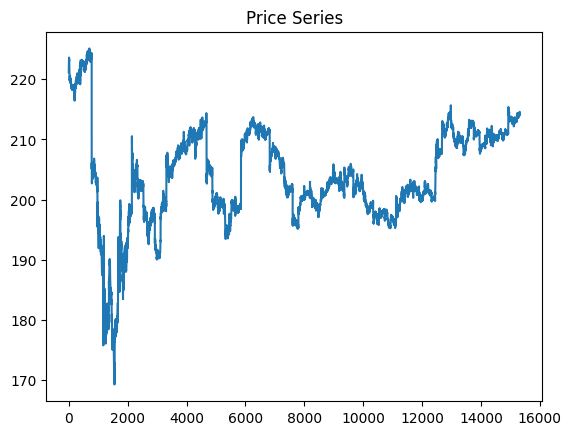

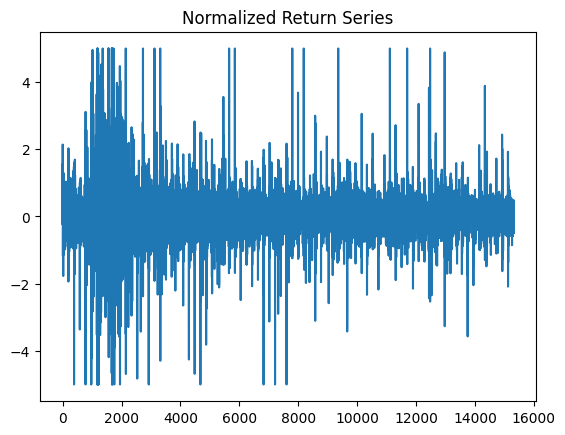

In [ ]:
#@title dataset
seq_dim = 60 #@param
steps = 30 #@param
ticker = "AAPL" #@param
outlier_thresh = 5.0 #@param
dataset = StandardizedReturnWFund(ticker=ticker, past=seq_dim, future=steps, dfs=dfs, mitigate_outliers=outlier_thresh)

save = False #@param
if save:
    pickle.dump(dataset, open(data_dir + f"/{ticker}_dataset_{seq_dim}in_{steps}out.pkl", "wb"))

## Train ABM Asset Return

In [ ]:
#@title training
val_alpha = 1e-0 #@param
vol_beta = 1e-1 #@param
skew_gamma = 1e-3 #@param
kurt_lambda = 1e-2 #@param
kl_theta = 0.0 #@param
n_agents = 20 #@param
n_strategies = 2 #@param
batch_size = 1024 #@param
num_epochs = 50 #@param
lr = 1e-2 #@param
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_len, val_len = int(0.8 * len(dataset)), int(0.2 * len(dataset))
train_dataset, val_dataset = torch.utils.data.Subset(dataset, range(train_len)), torch.utils.data.Subset(dataset, range(train_len, len(dataset)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

abm = ABM(seq_dim=seq_dim, fund_dim=3, mu=dataset.mu, sigma=dataset.sigma, n_agents=n_agents, n_strategies=n_strategies).to(device)
abm.to(device)
optimizer = torch.optim.Adam(abm.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_pred_loss = 0.0
    train_vol_loss = 0.0
    train_skew_loss = 0.0
    train_kurt_loss = 0.0
    train_kl_loss = 0.0
    val_pred_loss = 0.0
    val_vol_loss = 0.0
    val_skew_loss = 0.0
    val_kurt_loss = 0.0
    val_kl_loss = 0.0

    abm.train()
    for x, y, init_price in train_loader:
        x, y, init_price = x.to(device), y.to(device), init_price.to(device)
        z = dataset.feats.to(device)
        preds = abm(steps, x, z, init_price)
        loss, loss_pred, loss_vol, loss_skew, loss_kurt, loss_kl = abm.compute_loss(preds, y, val_alpha, vol_beta, skew_gamma, kurt_lambda, kl_theta)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_pred_loss += loss_pred.item()
        train_vol_loss += loss_vol.item()
        train_skew_loss += loss_skew.item()
        train_kurt_loss += loss_kurt.item()
        train_kl_loss += loss_kl.item()

    abm.eval()
    with torch.no_grad():
        for x, y, init_price in val_loader:
            x, y, init_price = x.to(device), y.to(device), init_price.to(device)
            z = dataset.feats.to(device)
            preds = abm(steps, x, z, init_price)
            loss, loss_pred, loss_vol, loss_skew, loss_kurt, loss_kl = abm.compute_loss(preds, y, val_alpha, vol_beta, skew_gamma, kurt_lambda, kl_theta)

            val_loss += loss.item()
            val_pred_loss += loss_pred.item()
            val_vol_loss += loss_vol.item()
            val_skew_loss += loss_skew.item()
            val_kurt_loss += loss_kurt.item()
            val_kl_loss += loss_kl.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_pred_loss /= len(train_loader)
    train_vol_loss /= len(train_loader)
    val_pred_loss /= len(val_loader)
    val_vol_loss /= len(val_loader)
    train_skew_loss /= len(train_loader)
    val_skew_loss /= len(val_loader)
    train_kurt_loss /= len(train_loader)
    val_kurt_loss /= len(val_loader)
    train_kl_loss /= len(train_loader)
    val_kl_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Pred Loss: {train_pred_loss:.4f}, Train Vol Loss: {train_vol_loss:.4f}, Train Skew Loss: {train_skew_loss:.4f}, Train Kurt Loss: {train_kurt_loss:.4f}, Train KL Loss: {train_kl_loss:.4f}")
    print(f"              Val Loss: {val_loss:.4f}, Val Pred Loss: {val_pred_loss:.4f}, Val Vol Loss: {val_vol_loss:.4f}, Val Skew Loss: {val_skew_loss:.4f}, Val Kurt Loss: {val_kurt_loss:.4f}, Val KL Loss: {val_kl_loss:.4f}")


Epoch 1/50, Train Loss: 0.8713, Train Pred Loss: 0.5715, Train Vol Loss: 0.5401, Train Skew Loss: 1.8679, Train Kurt Loss: 24.3872, Train KL Loss: 0.0000
              Val Loss: 0.3098, Val Pred Loss: 0.2265, Val Vol Loss: 0.1979, Val Skew Loss: 0.7525, Val Kurt Loss: 6.2841, Val KL Loss: 0.0000
Epoch 2/50, Train Loss: 0.7018, Train Pred Loss: 0.5737, Train Vol Loss: 0.4847, Train Skew Loss: 0.9705, Train Kurt Loss: 7.8664, Train KL Loss: 0.0000
              Val Loss: 0.3093, Val Pred Loss: 0.2307, Val Vol Loss: 0.1791, Val Skew Loss: 0.8081, Val Kurt Loss: 5.9830, Val KL Loss: 0.0000
Epoch 3/50, Train Loss: 0.6862, Train Pred Loss: 0.5703, Train Vol Loss: 0.4490, Train Skew Loss: 1.0383, Train Kurt Loss: 6.9990, Train KL Loss: 0.0000
              Val Loss: 0.3047, Val Pred Loss: 0.2323, Val Vol Loss: 0.1678, Val Skew Loss: 0.8476, Val Kurt Loss: 5.4783, Val KL Loss: 0.0000
Epoch 4/50, Train Loss: 0.6467, Train Pred Loss: 0.5531, Train Vol Loss: 0.3991, Train Skew Loss: 1.1807, Train

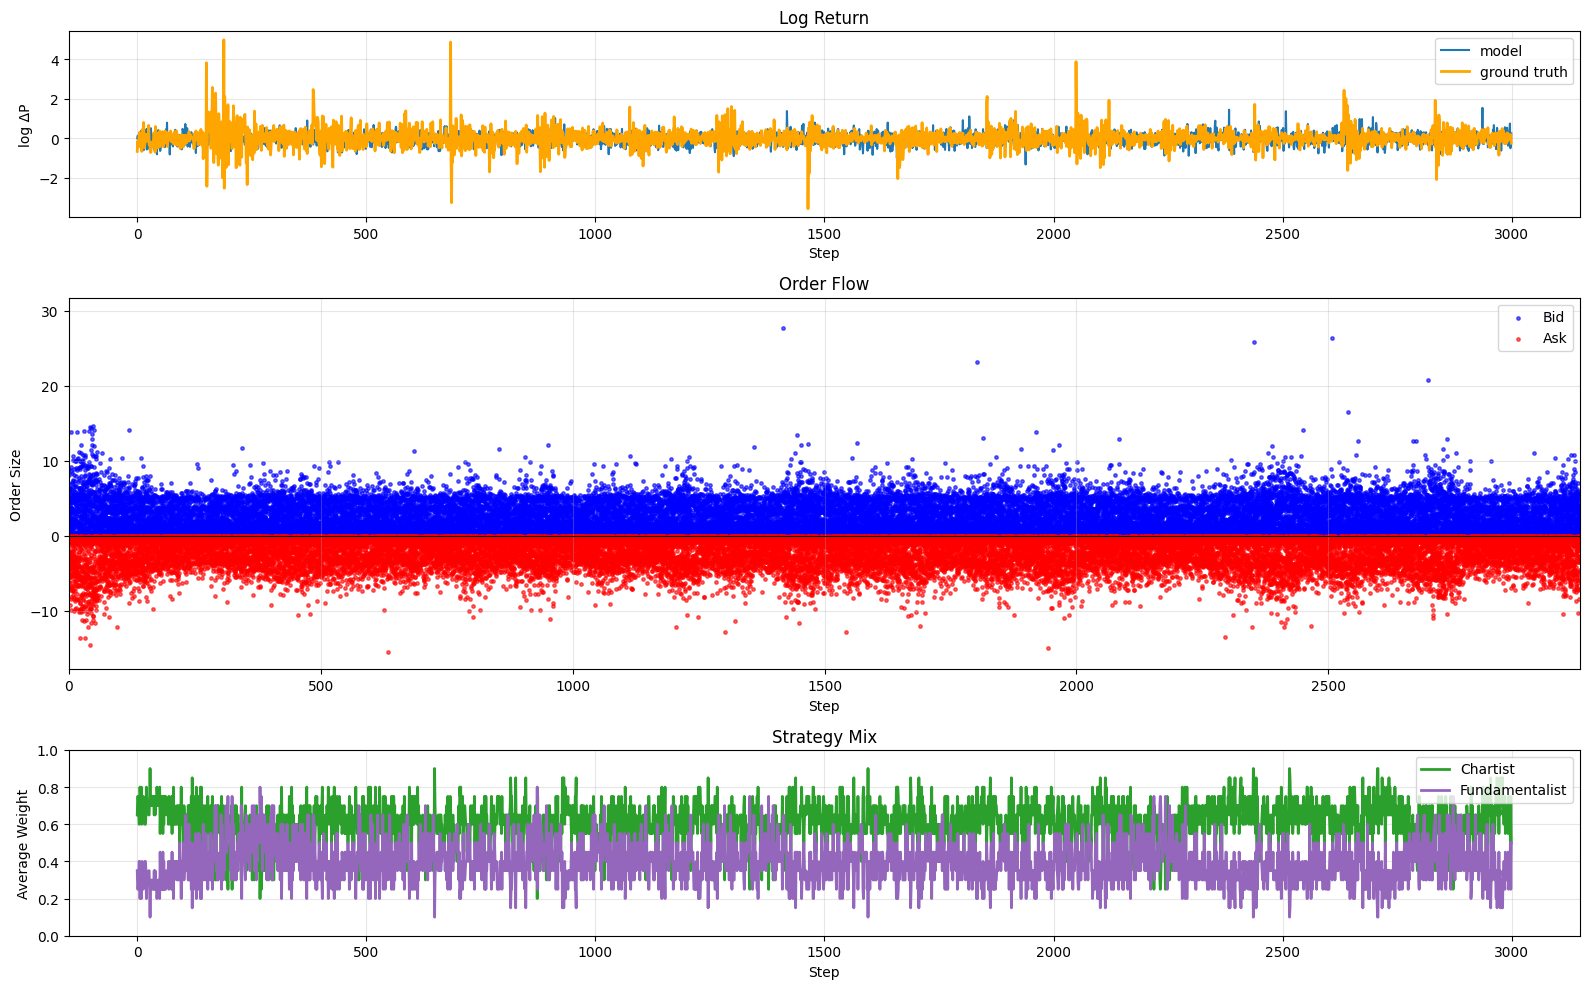

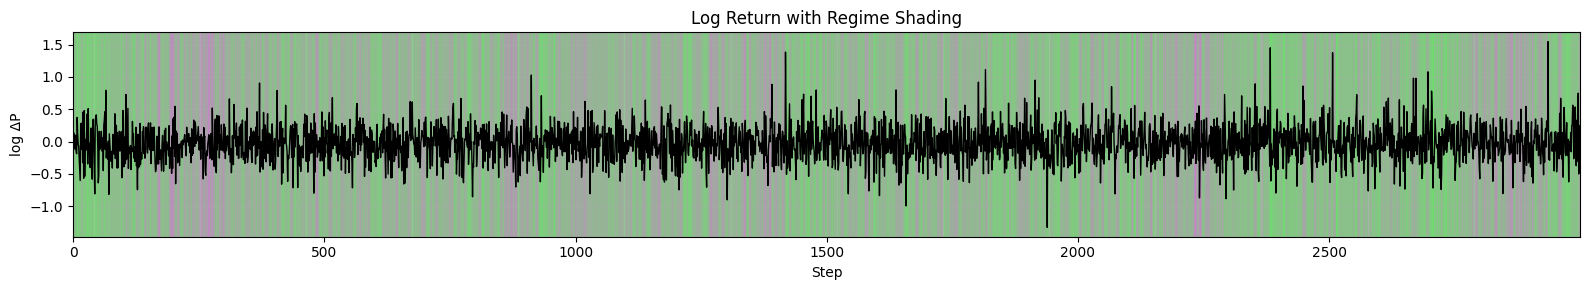

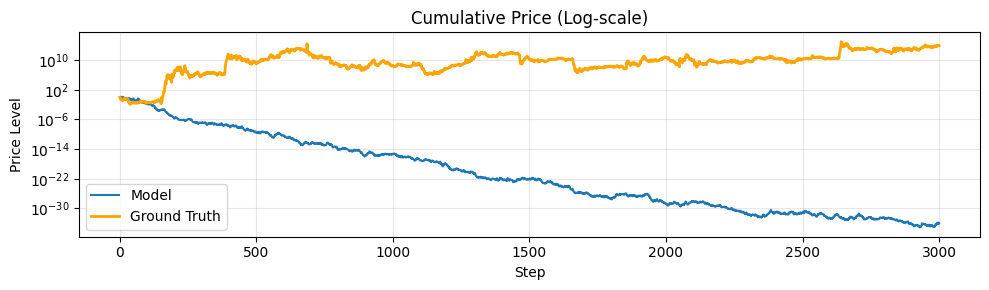

In [ ]:
abm.to("cpu")
idx = 50
sim_steps = 3000
input_dim = seq_dim
x = val_dataset[idx][0]
p = torch.tensor(val_dataset[idx][-1])
y = dataset.series[train_len+idx+input_dim:train_len+idx+input_dim+sim_steps]
z = dataset.feats
res = abm.simulate(x=x,
              z=z,
              price_level=p,
              steps=sim_steps,
              seed=0)
abm.visualize_simulation(res, y=y)

Shares:  tensor(1.4939e+10)
Assets:  tensor(3.3123e+11)
Debts:  tensor(9.8186e+10)
Net Income:  tensor(9.7294e+10)
Free Cash Flow:  tensor(9.8486e+10)
Common Stock Equity:  tensor(6.6796e+10)
            Treasury Shares Number  Ordinary Shares Number  Share Issued  \
2025-03-31                     NaN            1.493932e+10  1.493932e+10   
2024-12-31                     NaN            1.503787e+10  1.503787e+10   
2024-09-30                     NaN            1.511679e+10  1.511679e+10   
2024-06-30                     NaN            1.522226e+10  1.522226e+10   
2024-03-31                     NaN            1.533769e+10  1.533769e+10   
2023-12-31                     0.0                     NaN           NaN   

                Net Debt    Total Debt  Tangible Book Value  Invested Capital  \
2025-03-31  7.002400e+10  9.818600e+10         6.679600e+10      1.649820e+11   
2024-12-31  6.650000e+10  9.679900e+10         6.675800e+10      1.635570e+11   
2024-09-30  7.668600e+10  1.0662

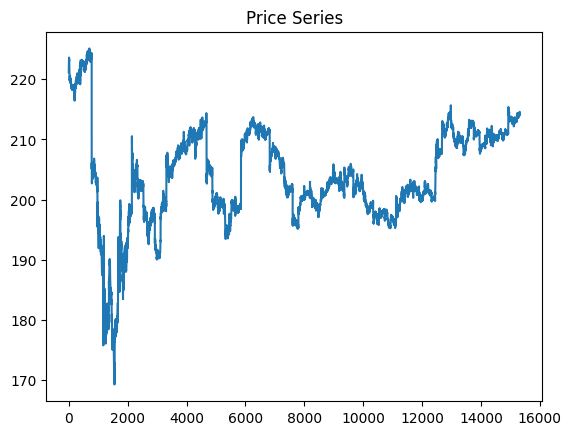

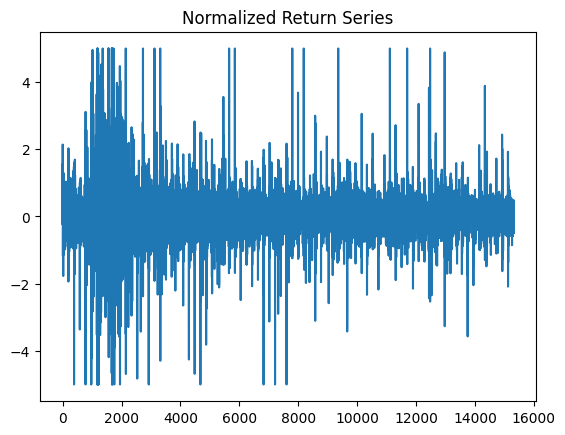

Evaluating 1000 samples with 30 steps each...

Collected 1000 simulated samples
Collected 1000 ground truth samples

ANALYZING FAT TAILS...


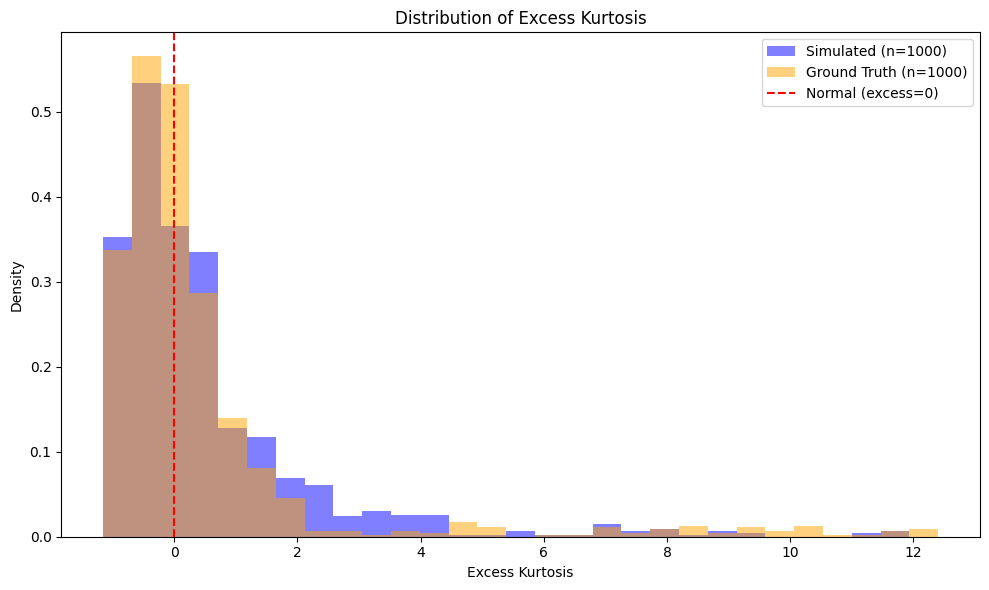


Excess Kurtosis Statistics:
--------------------------------------------------
Metric               Simulated       Ground Truth   
--------------------------------------------------
Count                1000            1000           
Mean                 0.5805          0.6498         
Std                  2.1291          2.6737         
Median               -0.0251         -0.0900        
25th percentile      -0.5454         -0.5244        
75th percentile      0.7511          0.4785         


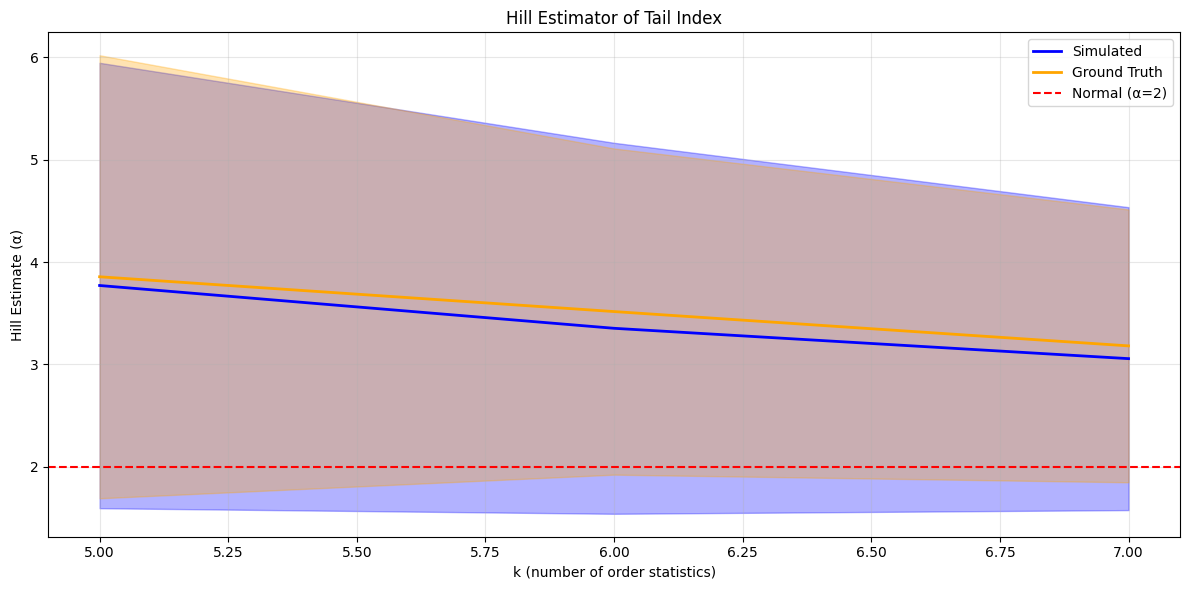


Hill Estimator Statistics (Mean ± Std):
------------------------------------------------------------
k          Simulated                 Ground Truth             
------------------------------------------------------------
5          3.7718 ± 2.1762           3.8571 ± 2.1645          
6          3.3536 ± 1.8126           3.5171 ± 1.5936          
7          3.0571 ± 1.4800           3.1818 ± 1.3329          


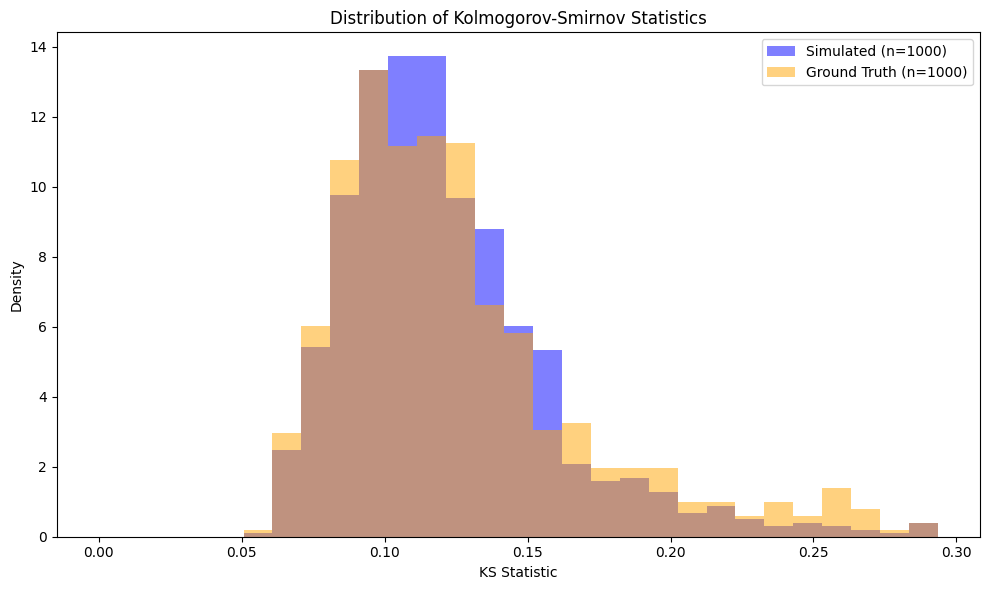


Kolmogorov-Smirnov Test Statistics:
--------------------------------------------------
Metric               Simulated       Ground Truth   
--------------------------------------------------
Count                1000            1000           
Mean KS stat         0.1214          0.1255         
Std KS stat          0.0368          0.0440         
Median KS stat       0.1146          0.1155         
% Reject (p<0.05)    1.5             3.5            


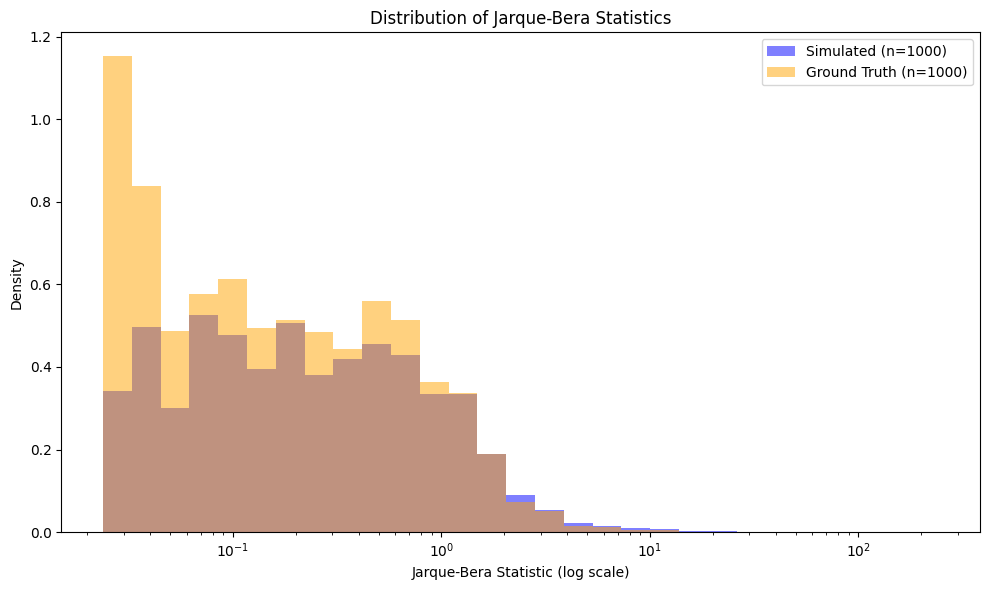


Jarque-Bera Test Statistics:
--------------------------------------------------
Metric               Simulated       Ground Truth   
--------------------------------------------------
Count                1000            1000           
Mean JB stat         8.7261          12.8751        
Std JB stat          34.2911         49.0161        
Median JB stat       1.2978          1.0724         
% Reject (p<0.05)    16.6            11.8           

ANALYZING VOLATILITY CLUSTERING...
Computing Ljung-Box tests...


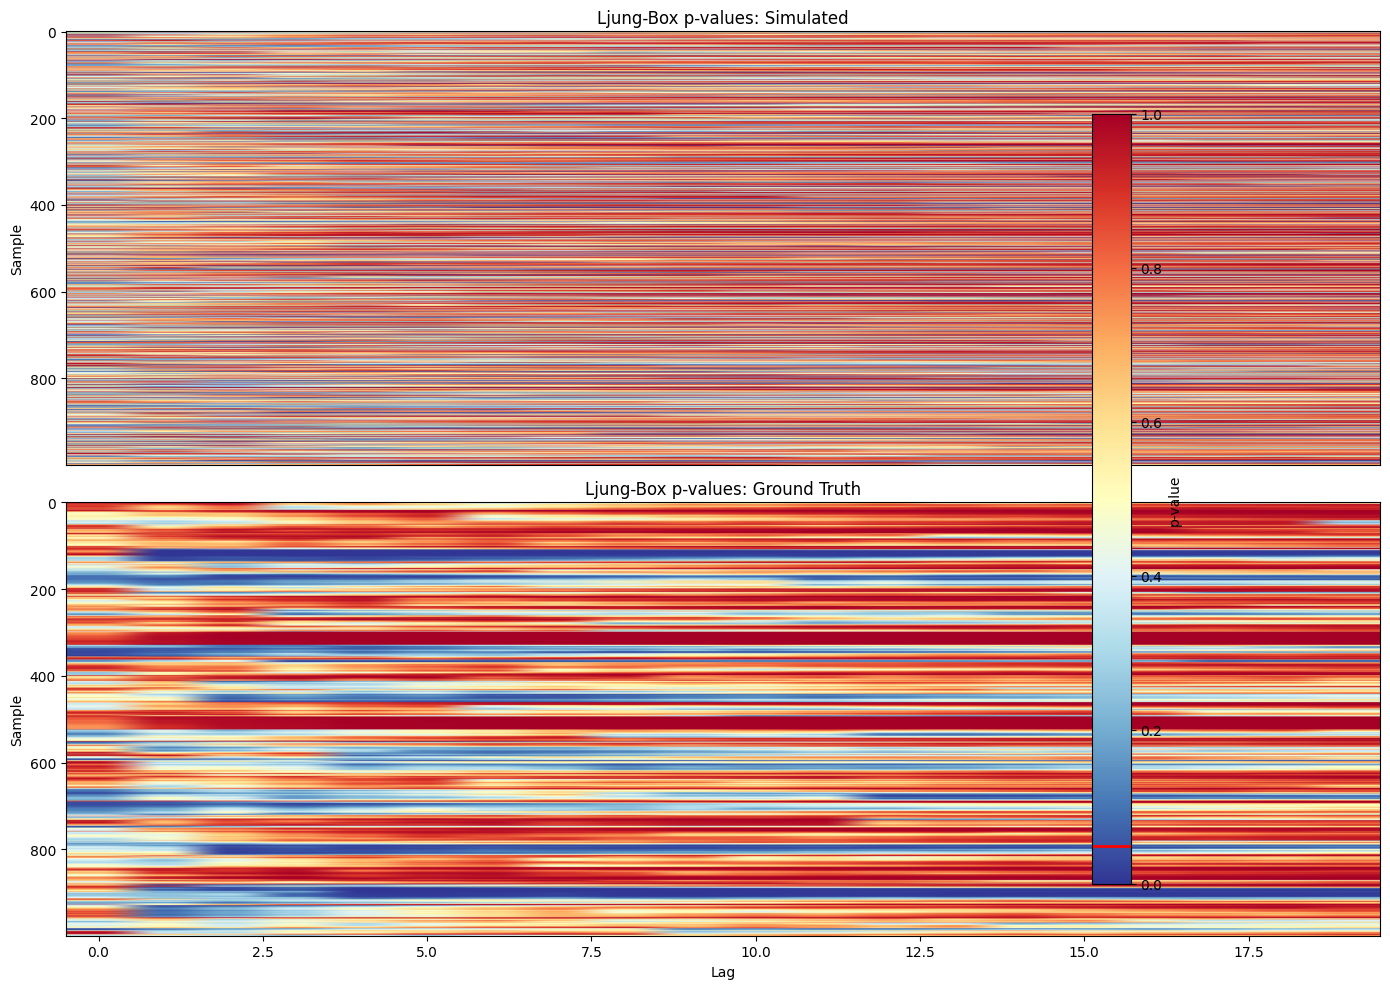

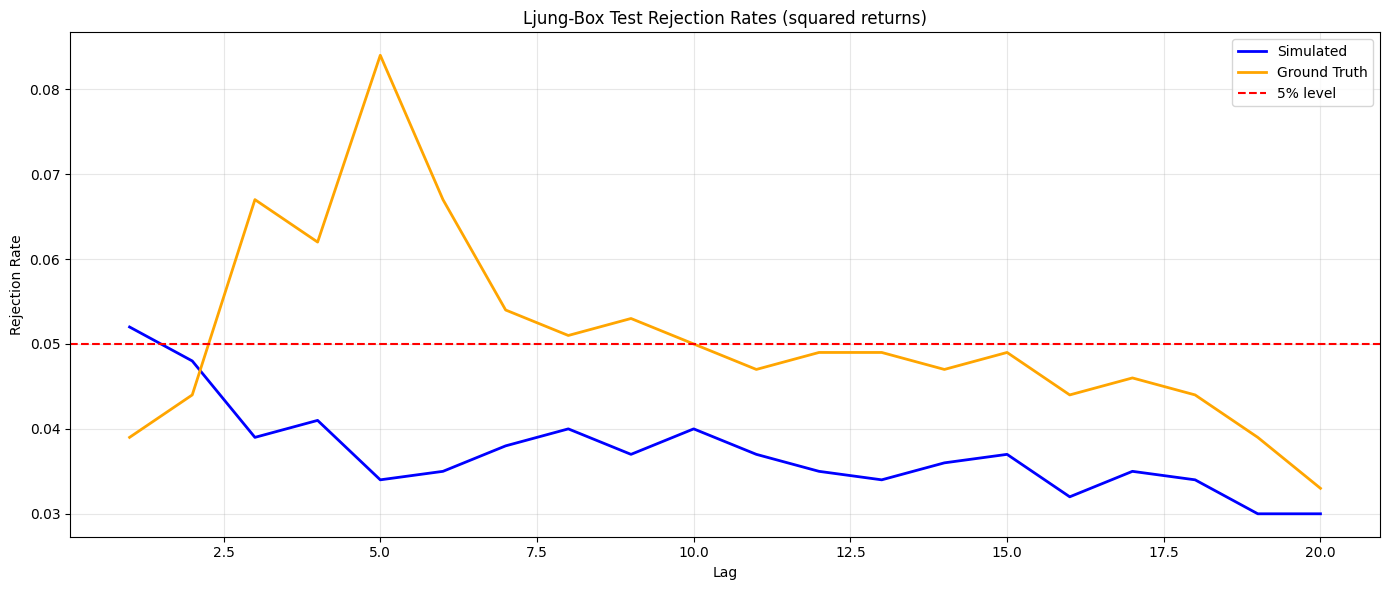


Ljung-Box Rejection Rates (p < 0.05):
--------------------------------------------------
Lag        Simulated            Ground Truth        
--------------------------------------------------
1          0.052                0.039               
2          0.048                0.044               
3          0.039                0.067               
4          0.041                0.062               
5          0.034                0.084               
6          0.035                0.067               
7          0.038                0.054               
8          0.040                0.051               
9          0.037                0.053               
10         0.040                0.050               
11         0.037                0.047               
12         0.035                0.049               
13         0.034                0.049               
14         0.036                0.047               
15         0.037                0.049               
16         

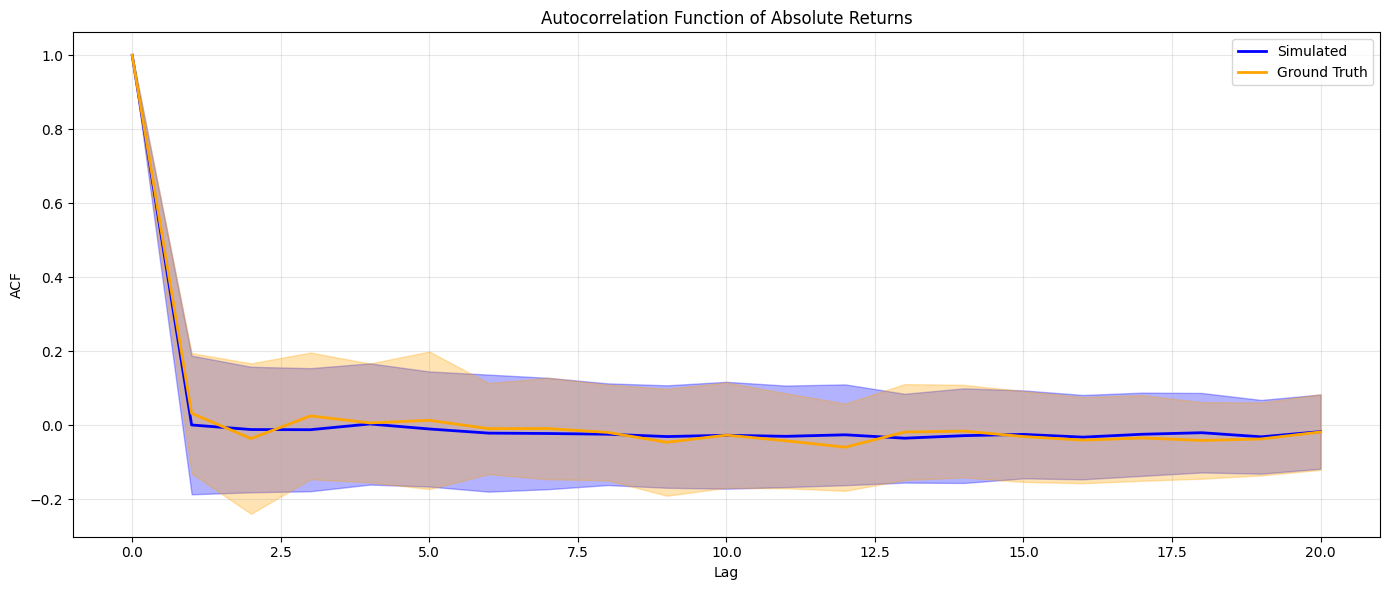


ACF of Absolute Returns (Mean ± Std):
------------------------------------------------------------
Lag        Simulated                 Ground Truth             
------------------------------------------------------------
0          1.0000 ± 0.0000           1.0000 ± 0.0000          
1          0.0012 ± 0.1873           0.0327 ± 0.1626          
2          -0.0111 ± 0.1696          -0.0355 ± 0.2032         
3          -0.0115 ± 0.1662          0.0258 ± 0.1711          
4          0.0039 ± 0.1638           0.0067 ± 0.1605          
5          -0.0096 ± 0.1555          0.0138 ± 0.1857          
6          -0.0208 ± 0.1581          -0.0087 ± 0.1230         
7          -0.0218 ± 0.1504          -0.0084 ± 0.1372         
8          -0.0237 ± 0.1374          -0.0188 ± 0.1293         
9          -0.0301 ± 0.1384          -0.0455 ± 0.1444         
10         -0.0265 ± 0.1443          -0.0262 ± 0.1423         
11         -0.0294 ± 0.1371          -0.0414 ± 0.1283         
12         -0.0253 ±

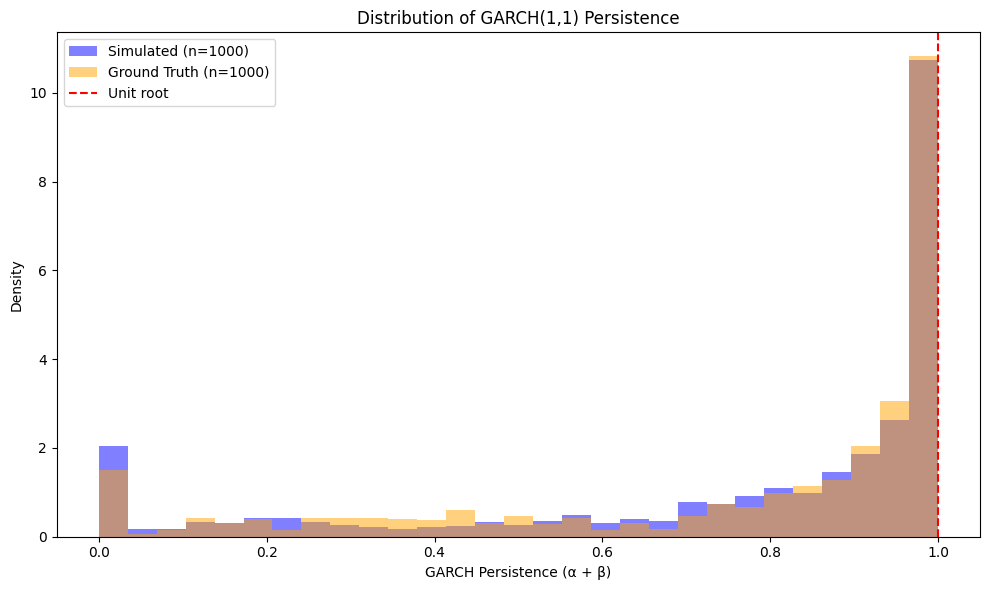


GARCH(1,1) Persistence Statistics:
--------------------------------------------------
Metric               Simulated       Ground Truth   
--------------------------------------------------
Count                1000            1000           
Mean                 0.7607          0.7757         
Std                  0.3162          0.3038         
Median               0.9178          0.9345         
25th percentile      0.6675          0.6700         
75th percentile      0.9872          0.9895         

ANALYZING LONG MEMORY...
Computing Hurst exponents...
Computing DFA exponents...
Computing GPH estimates...


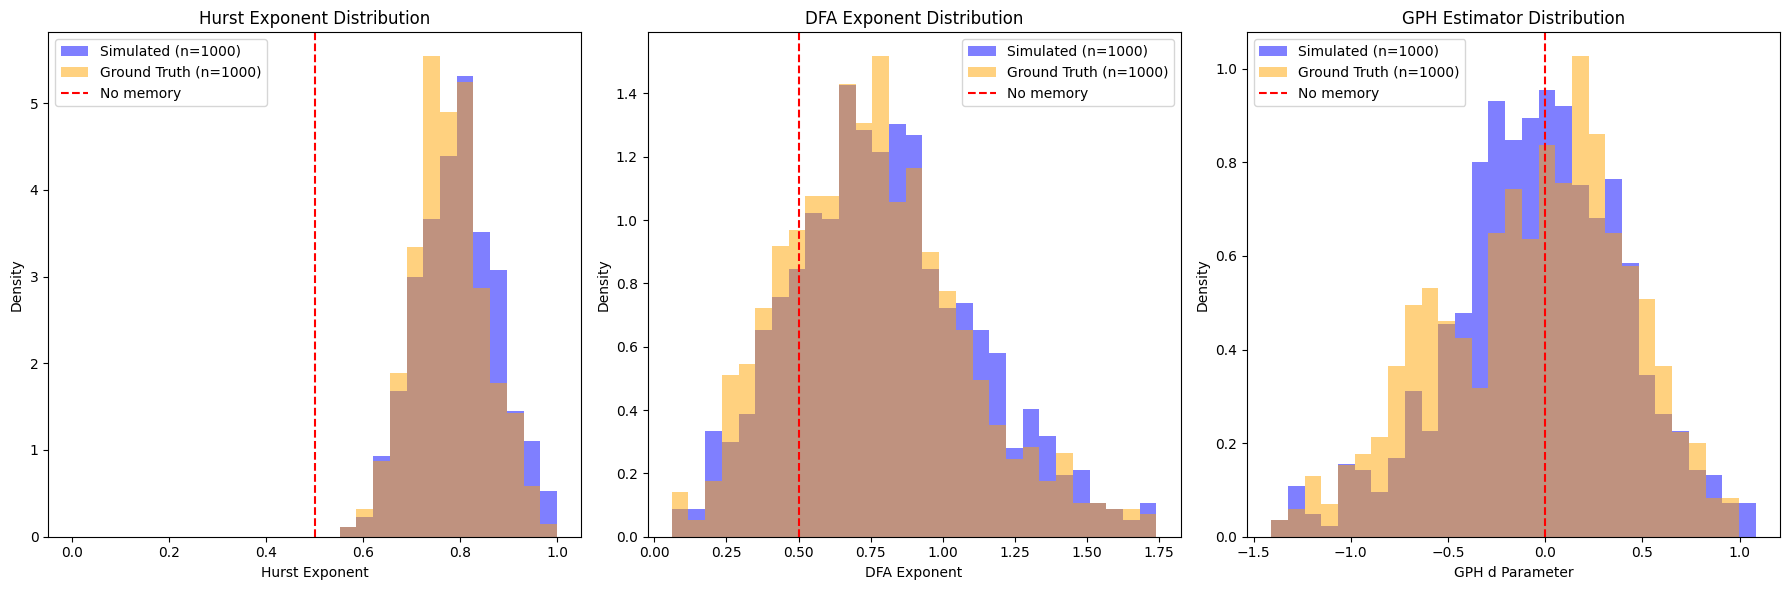


Long Memory Statistics:
--------------------------------------------------------------------------------
Method          Metric          Simulated            Ground Truth        
--------------------------------------------------------------------------------
Hurst R/S       Count           1000                 1000                
                Mean            0.7954               0.7784              
                Std             0.0818               0.0741              
                Median          0.7977               0.7774              
                95% CI          [0.6402, 0.9597] [0.6399, 0.9310]
--------------------------------------------------------------------------------
DFA             Count           1000                 1000                
                Mean            0.8057               0.7605              
                Std             0.3478               0.3386              
                Median          0.7751               0.7415              


In [ ]:
sim_steps = 30
eval_dataset = StandardizedReturnWFund(ticker=ticker, past=seq_dim, future=sim_steps, dfs=dfs, mitigate_outliers=outlier_thresh)
eval_res = abm.evaluate(dataset=eval_dataset, sim_steps=sim_steps, n_samples=1000, max_lag=20)

       ABM parameter summary

Agent-level parameters:
      momentum  revert
mean    0.0573  0.8032
std     1.0048  0.4625
min    -2.1170  0.0909
max     1.7547  1.8159

Market-impact function:
  price_t+1 = price_t + -0.1639 + 0.8471 · imbalance
        μ  (drift)   : -0.1639
        α_t (impact) : 0.8471


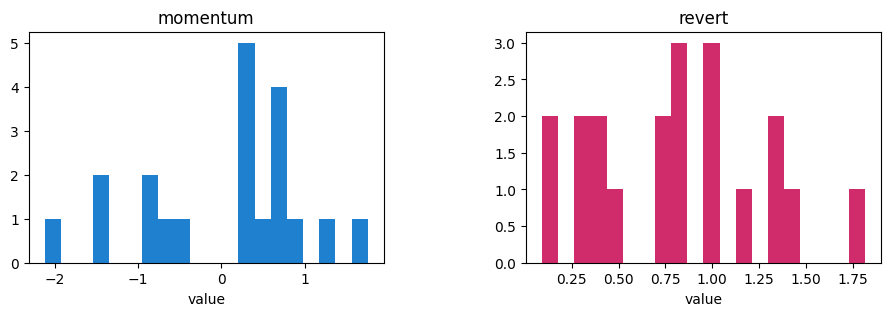

In [ ]:
sumr = abm.summary()

In [ ]:
# Save the trained ABM model
abm_save_path = os.path.join(data_dir, f"abm_model_{ticker}_{seq_dim}in_{steps}out.pkl")
with open(abm_save_path, "wb") as f:
    pickle.dump(abm.state_dict(), f)
print(f"ABM model state_dict saved to: {abm_save_path}")

# Save the evaluation results
eval_results_save_path = os.path.join(data_dir, f"abm_eval_results_{ticker}_{seq_dim}in_{sim_steps}simsteps.pkl")
with open(eval_results_save_path, "wb") as f:
    pickle.dump(eval_res, f)
print(f"Evaluation results saved to: {eval_results_save_path}")

ABM model state_dict saved to: /content/drive/MyDrive/Undergrad Thesis/Deep Agent-Based Model/data/abm_model_AAPL_60in_30out.pkl
Evaluation results saved to: /content/drive/MyDrive/Undergrad Thesis/Deep Agent-Based Model/data/abm_eval_results_AAPL_60in_30simsteps.pkl


## Train ARFIMA-t-GARCH

In [ ]:
# Fit ARFIMA-t-GARCH on your dataset
train_len, val_len = int(0.8 * len(dataset)), int(0.2 * len(dataset))
atg_model = ARFIMA_t_GARCH(dataset.series[:train_len].numpy())
atg_model.fit(arfima_order=(1, 0.0, 1), garch_order=(1, 1))

Estimating ARFIMA-t-GARCH model parameters...

Optimization successful!


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 9011.119081108714
        x: [ 2.475e-03  1.750e-02  1.036e-02 -2.850e-02  3.105e-03
             7.484e-02  8.675e-01  4.841e+00]
      nit: 57
      jac: [-6.941e-01 -4.180e-01 -3.423e-01 -7.387e-01  1.610e+00
            -4.975e-01  6.303e-01 -1.819e-03]
     nfev: 603
     njev: 67
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [ ]:
atg_results = atg_model.evaluate(
    dataset=eval_dataset,
    sim_steps=30,
    n_samples=1000,
    max_lag=20
)

Evaluating 1000 samples with 30 steps each...

Collected 1000 simulated samples
Collected 1000 ground truth samples

ANALYZING FAT TAILS...

Fat Tails Summary:
--------------------------------------------------
Metric               Simulated       Ground Truth   
--------------------------------------------------
Excess Kurtosis     
  Mean               1.2810          0.6498         
  Std                2.1954          2.6737         
KS Statistic        
  Mean               0.1291          0.1255         

ANALYZING VOLATILITY CLUSTERING...

Fitting GARCH(1,1) models...
  Processing simulation 0...
  Processing simulation 50...
  Processing simulation 100...
  Processing simulation 150...
  Processing simulation 200...
  Processing simulation 250...
  Processing simulation 300...
  Processing simulation 350...
  Processing simulation 400...
  Processing simulation 450...
  Processing simulation 500...
  Processing simulation 550...
  Processing simulation 600...
  Processing simul

In [ ]:
# Save the fitted ARFIMA-t-GARCH model
atg_save_path = os.path.join(data_dir, f"atg_model_{ticker}_{seq_dim}in_{steps}out.pkl")
with open(atg_save_path, "wb") as f:
    pickle.dump(atg_model, f)
print(f"ARFIMA-t-GARCH model saved to: {atg_save_path}")

# Save the ARFIMA-t-GARCH evaluation results
atg_eval_results_save_path = os.path.join(data_dir, f"atg_eval_results_{ticker}_{seq_dim}in_{sim_steps}simsteps.pkl")
with open(atg_eval_results_save_path, "wb") as f:
    pickle.dump(atg_results, f)
print(f"ARFIMA-t-GARCH evaluation results saved to: {atg_eval_results_save_path}")

ARFIMA-t-GARCH model saved to: /content/drive/MyDrive/Undergrad Thesis/Deep Agent-Based Model/data/atg_model_AAPL_60in_30out.pkl
ARFIMA-t-GARCH evaluation results saved to: /content/drive/MyDrive/Undergrad Thesis/Deep Agent-Based Model/data/atg_eval_results_AAPL_60in_30simsteps.pkl


## Comparison


EXCESS KURTOSIS COMPARISON

Excess Kurtosis Statistics:
------------------------------------------------------------
Model      Mean         Median       Std          Count     
------------------------------------------------------------
ABM        0.5805       -0.0251      2.1291       1000      
AtG        1.2810       0.6619       2.1954       1000      
Real       0.6498       -0.0900      2.6737       1000      

KS test (ABM vs AtG): statistic=0.2500, p-value=0.0000
KS test (ABM vs Real): statistic=0.0920, p-value=0.0004
KS test (AtG vs Real): statistic=0.3130, p-value=0.0000

KOLMOGOROV-SMIRNOV STATISTICS COMPARISON

KS Statistic Statistics:
------------------------------------------------------------
Model      Mean         Median       Std          Count     
------------------------------------------------------------
ABM        0.1214       0.1146       0.0368       1000      
AtG        0.1291       0.1221       0.0384       1000      
Real       0.1255       0.1155      

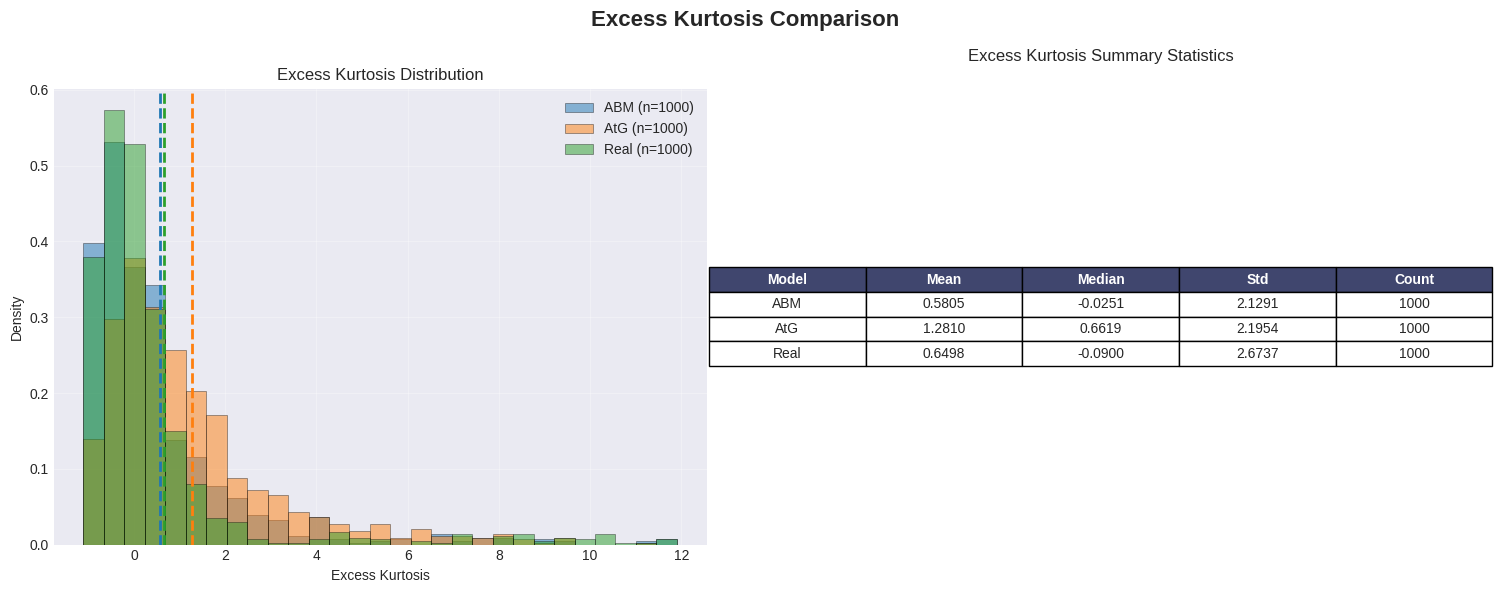

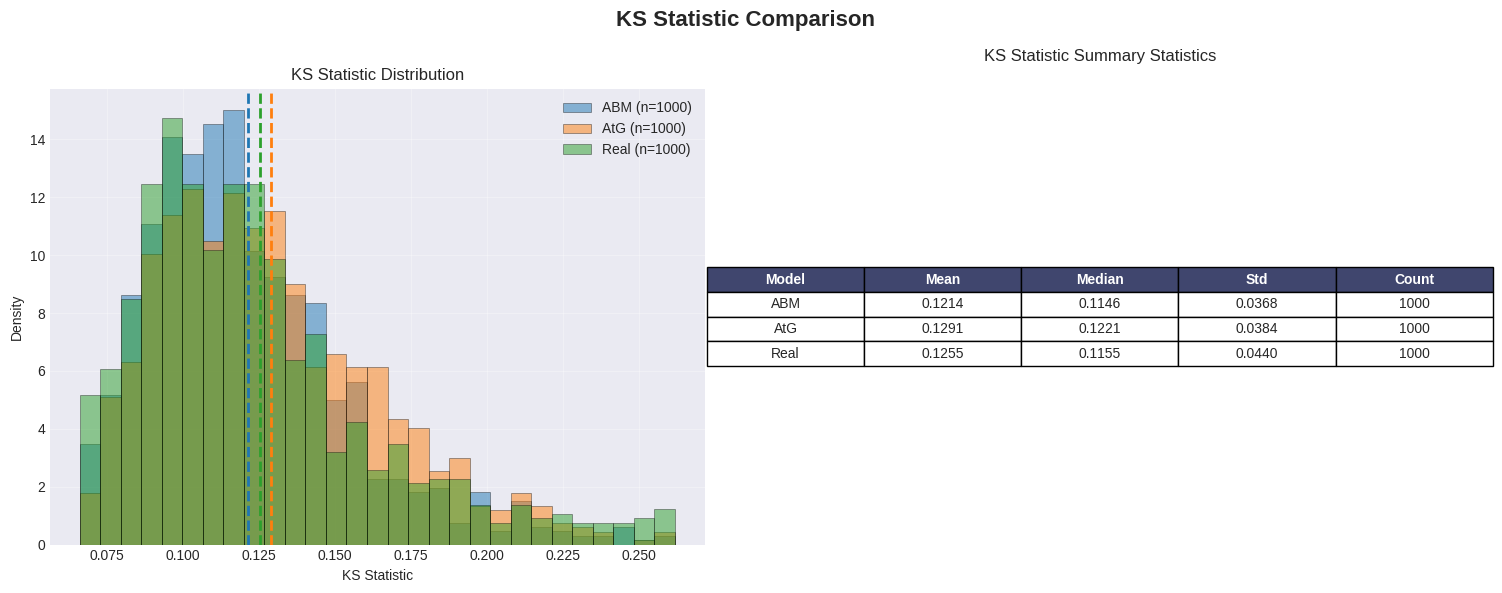

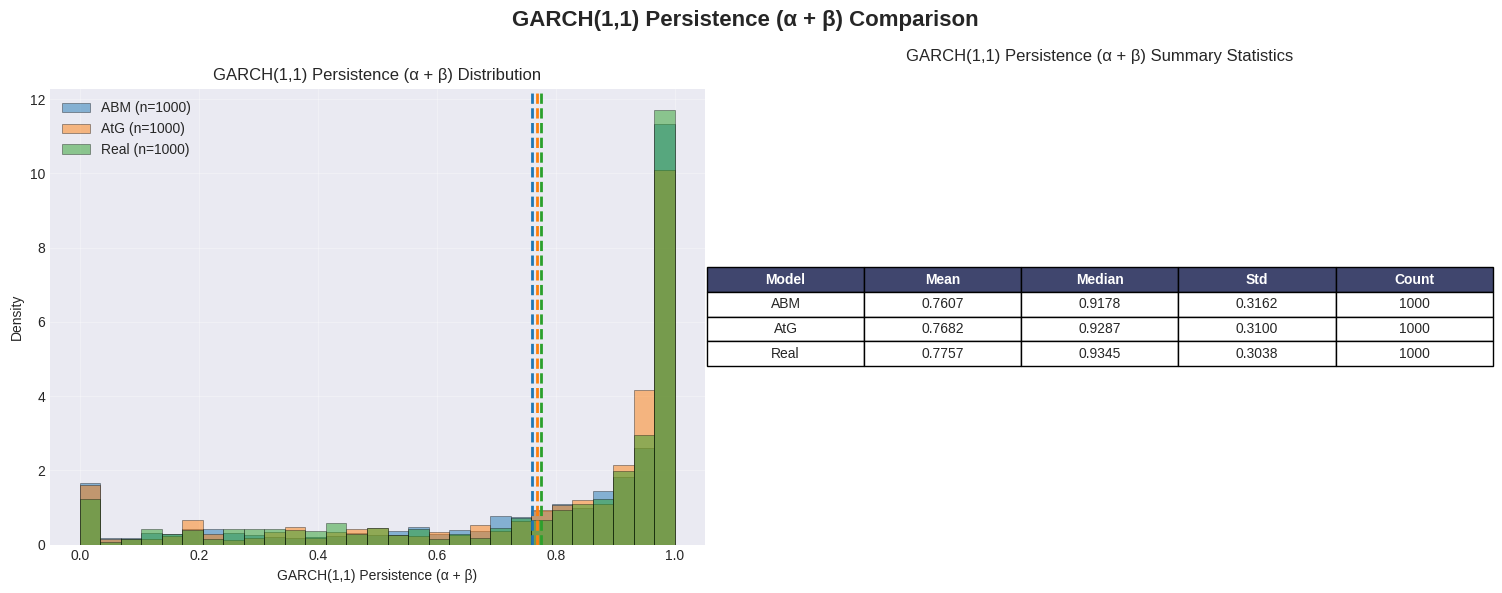

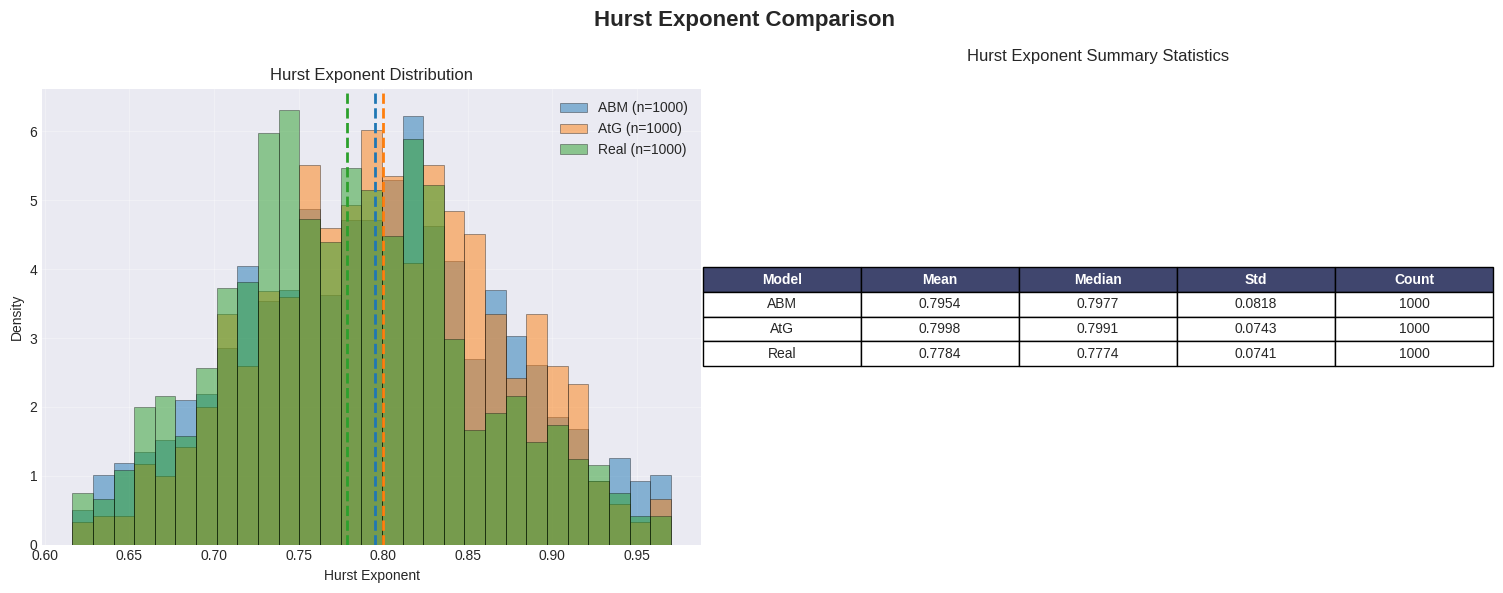

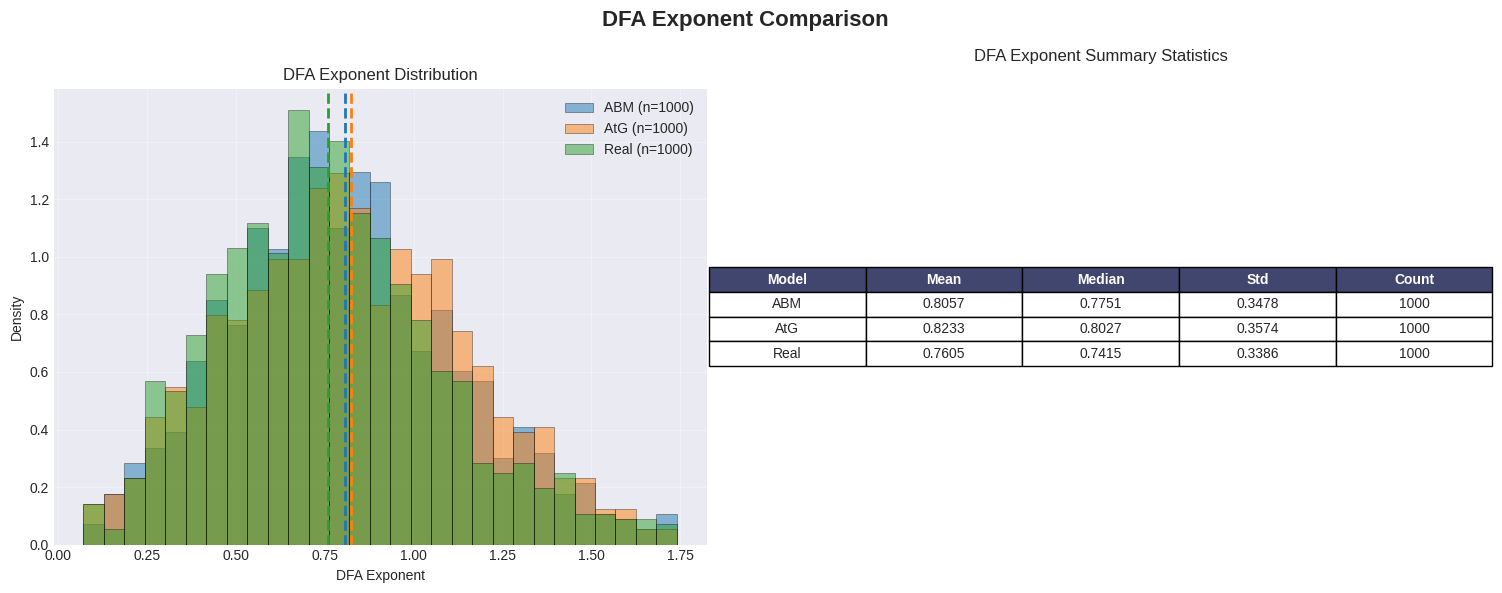

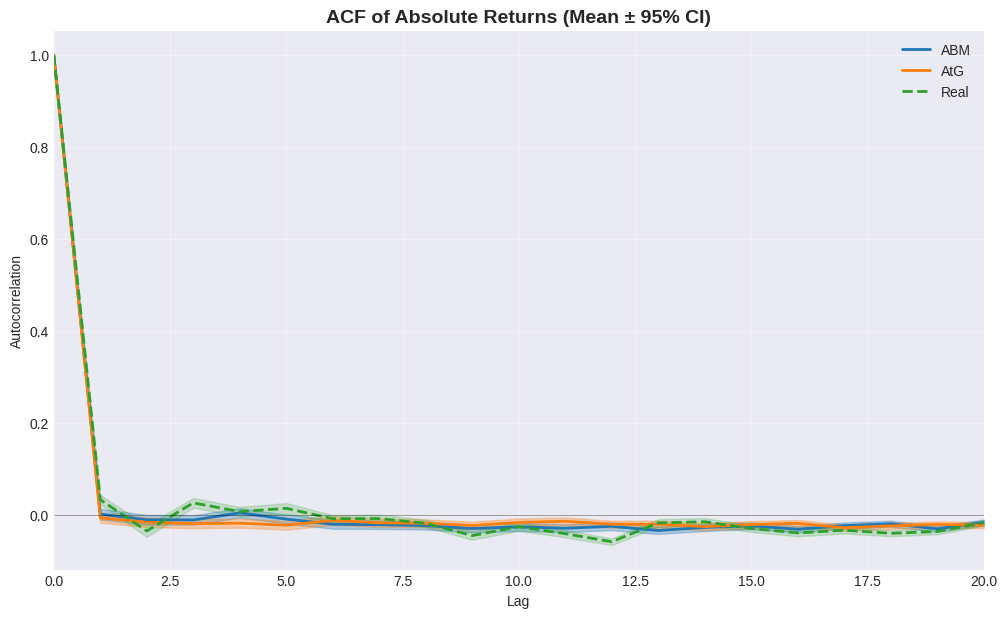

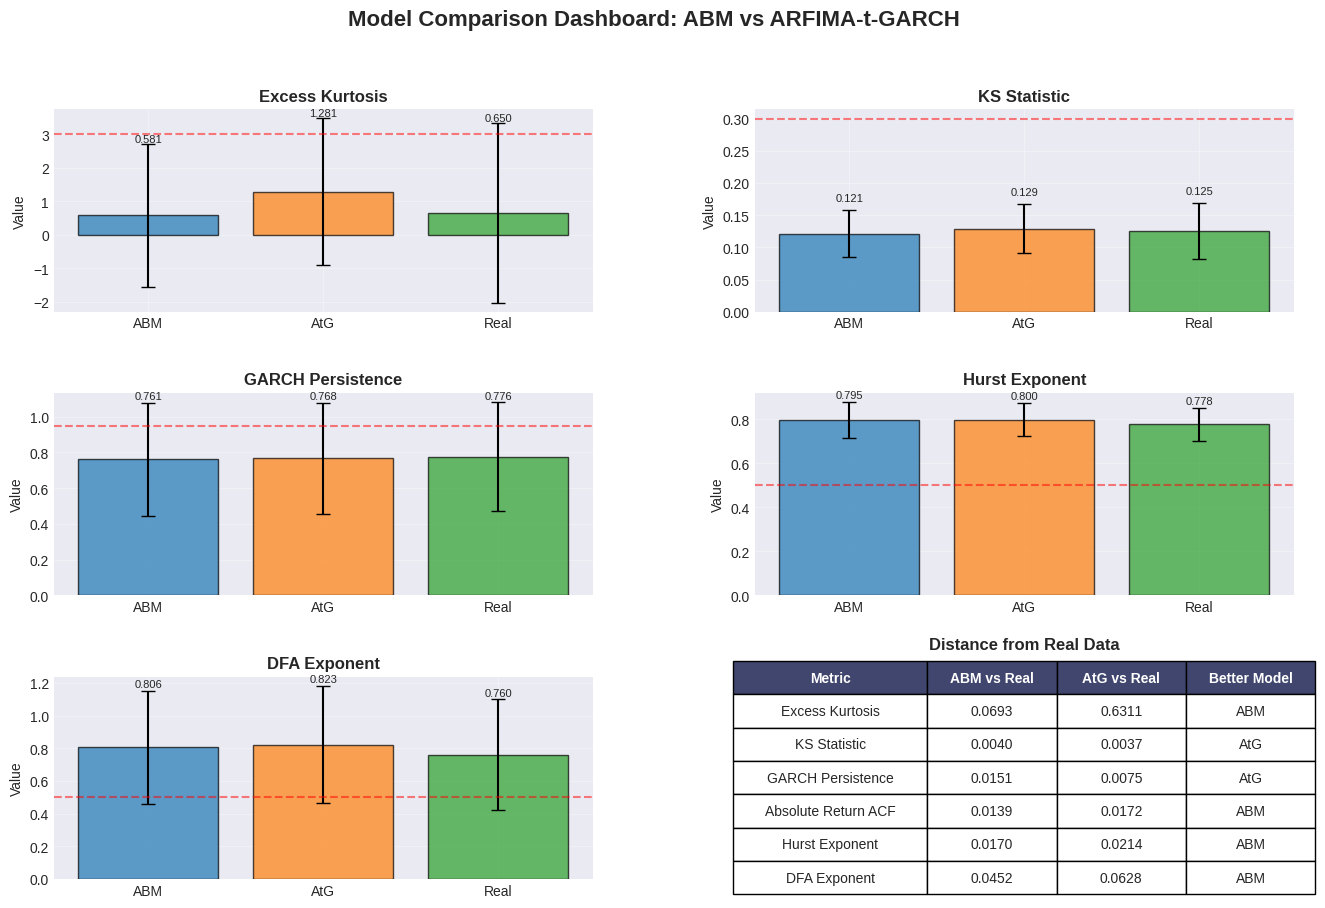

Comparison complete!


In [ ]:
#@title compare
"""
Model Comparison: ABM vs ARFIMA-t-GARCH
=======================================
Comprehensive comparison of stylized facts between models
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def compare_models(eval_res, atg_results, save_plots=False):
    """
    Compare ABM and ARFIMA-t-GARCH results

    Parameters:
    -----------
    eval_res : dict
        ABM evaluation results
    atg_results : dict
        ARFIMA-t-GARCH evaluation results
    save_plots : bool
        Whether to save plots to files
    """

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    colors = {'ABM': '#1f77b4', 'AtG': '#ff7f0e', 'Real': '#2ca02c'}

    # Create summary statistics table
    summary_stats = create_summary_table(eval_res, atg_results)

    # 1. Excess Kurtosis Comparison
    print("\n" + "="*80)
    print("EXCESS KURTOSIS COMPARISON")
    print("="*80)
    fig1 = plot_metric_comparison(
        eval_res['fat_tails']['sim_excess_kurt'],
        atg_results['fat_tails']['sim_excess_kurt'],
        eval_res['fat_tails']['gt_excess_kurt'],
        'Excess Kurtosis',
        colors,
        summary_stats['Excess Kurtosis']
    )
    if save_plots:
        fig1.savefig('excess_kurtosis_comparison.png', dpi=300, bbox_inches='tight')

    # 2. KS Statistics Comparison
    print("\n" + "="*80)
    print("KOLMOGOROV-SMIRNOV STATISTICS COMPARISON")
    print("="*80)
    fig2 = plot_metric_comparison(
        eval_res['fat_tails']['sim_ks_stats'],
        atg_results['fat_tails']['sim_ks_stats'],
        eval_res['fat_tails']['gt_ks_stats'],
        'KS Statistic',
        colors,
        summary_stats['KS Statistic']
    )
    if save_plots:
        fig2.savefig('ks_statistics_comparison.png', dpi=300, bbox_inches='tight')

    # 3. GARCH Persistence Comparison
    print("\n" + "="*80)
    print("GARCH(1,1) PERSISTENCE COMPARISON")
    print("="*80)
    fig3 = plot_metric_comparison(
        eval_res['vol_clustering']['sim_persistence'],
        atg_results['vol_clustering']['sim_persistence'],
        eval_res['vol_clustering']['gt_persistence'],
        'GARCH(1,1) Persistence (α + β)',
        colors,
        summary_stats['GARCH Persistence']
    )
    if save_plots:
        fig3.savefig('garch_persistence_comparison.png', dpi=300, bbox_inches='tight')

    # 4. Hurst Exponent Comparison
    print("\n" + "="*80)
    print("HURST EXPONENT COMPARISON")
    print("="*80)
    fig4 = plot_metric_comparison(
        eval_res['long_memory']['sim_hurst'],
        atg_results['long_memory']['sim_hurst'],
        eval_res['long_memory']['gt_hurst'],
        'Hurst Exponent',
        colors,
        summary_stats['Hurst Exponent']
    )
    if save_plots:
        fig4.savefig('hurst_exponent_comparison.png', dpi=300, bbox_inches='tight')

    # 5. DFA Exponent Comparison
    print("\n" + "="*80)
    print("DFA EXPONENT COMPARISON")
    print("="*80)
    fig5 = plot_metric_comparison(
        eval_res['long_memory']['sim_dfa'],
        atg_results['long_memory']['sim_dfa'],
        eval_res['long_memory']['gt_dfa'],
        'DFA Exponent',
        colors,
        summary_stats['DFA Exponent']
    )
    if save_plots:
        fig5.savefig('dfa_exponent_comparison.png', dpi=300, bbox_inches='tight')

    # 6. ACF of Absolute Returns Comparison
    print("\n" + "="*80)
    print("ACF OF ABSOLUTE RETURNS COMPARISON")
    print("="*80)
    fig6 = plot_acf_comparison(eval_res, atg_results, colors)
    if save_plots:
        fig6.savefig('acf_absolute_returns_comparison.png', dpi=300, bbox_inches='tight')

    # 7. Overall Summary Dashboard
    print("\n" + "="*80)
    print("OVERALL SUMMARY DASHBOARD")
    print("="*80)
    fig7 = create_summary_dashboard(summary_stats)
    if save_plots:
        fig7.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')

    plt.show()

    return summary_stats


def create_summary_table(eval_res, atg_results):
    """Create summary statistics table"""

    metrics = {
        'Excess Kurtosis': {
            'ABM': eval_res['fat_tails']['sim_excess_kurt'],
            'AtG': atg_results['fat_tails']['sim_excess_kurt'],
            'Real': eval_res['fat_tails']['gt_excess_kurt']
        },
        'KS Statistic': {
            'ABM': eval_res['fat_tails']['sim_ks_stats'],
            'AtG': atg_results['fat_tails']['sim_ks_stats'],
            'Real': eval_res['fat_tails']['gt_ks_stats']
        },
        'GARCH Persistence': {
            'ABM': eval_res['vol_clustering']['sim_persistence'],
            'AtG': atg_results['vol_clustering']['sim_persistence'],
            'Real': eval_res['vol_clustering']['gt_persistence']
        },
        'Hurst Exponent': {
            'ABM': eval_res['long_memory']['sim_hurst'],
            'AtG': atg_results['long_memory']['sim_hurst'],
            'Real': eval_res['long_memory']['gt_hurst']
        },
        'DFA Exponent': {
            'ABM': eval_res['long_memory']['sim_dfa'],
            'AtG': atg_results['long_memory']['sim_dfa'],
            'Real': eval_res['long_memory']['gt_dfa']
        }
    }

    summary = {}

    for metric_name, data in metrics.items():
        summary[metric_name] = {}
        for model_name, values in data.items():
            if len(values) > 0:
                summary[metric_name][model_name] = {
                    'mean': np.mean(values),
                    'median': np.median(values),
                    'std': np.std(values),
                    'count': len(values)
                }
            else:
                summary[metric_name][model_name] = {
                    'mean': np.nan,
                    'median': np.nan,
                    'std': np.nan,
                    'count': 0
                }

    return summary


def plot_metric_comparison(abm_data, atg_data, real_data, metric_name, colors, summary):
    """Plot comparison for a single metric"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Left plot: Histograms
    ax1 = axes[0]

    # Determine bins
    all_data = np.concatenate([d for d in [abm_data, atg_data, real_data] if len(d) > 0])
    if len(all_data) > 0:
        bins = np.linspace(np.percentile(all_data, 1), np.percentile(all_data, 99), 30)

        # Plot histograms
        if len(abm_data) > 0:
            ax1.hist(abm_data, bins=bins, alpha=0.5, label=f'ABM (n={len(abm_data)})',
                    color=colors['ABM'], density=True, edgecolor='black', linewidth=0.5)
        if len(atg_data) > 0:
            ax1.hist(atg_data, bins=bins, alpha=0.5, label=f'AtG (n={len(atg_data)})',
                    color=colors['AtG'], density=True, edgecolor='black', linewidth=0.5)
        if len(real_data) > 0:
            ax1.hist(real_data, bins=bins, alpha=0.5, label=f'Real (n={len(real_data)})',
                    color=colors['Real'], density=True, edgecolor='black', linewidth=0.5)

        # Add vertical lines for means
        if len(abm_data) > 0:
            ax1.axvline(np.mean(abm_data), color=colors['ABM'], linestyle='--', linewidth=2)
        if len(atg_data) > 0:
            ax1.axvline(np.mean(atg_data), color=colors['AtG'], linestyle='--', linewidth=2)
        if len(real_data) > 0:
            ax1.axvline(np.mean(real_data), color=colors['Real'], linestyle='--', linewidth=2)

    ax1.set_xlabel(metric_name)
    ax1.set_ylabel('Density')
    ax1.set_title(f'{metric_name} Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Right plot: Summary statistics table
    ax2 = axes[1]
    ax2.axis('tight')
    ax2.axis('off')

    # Create table data
    table_data = []
    headers = ['Model', 'Mean', 'Median', 'Std', 'Count']

    for model in ['ABM', 'AtG', 'Real']:
        if model in summary and summary[model]['count'] > 0:
            row = [
                model,
                f"{summary[model]['mean']:.4f}",
                f"{summary[model]['median']:.4f}",
                f"{summary[model]['std']:.4f}",
                f"{summary[model]['count']}"
            ]
            table_data.append(row)

    # Create table
    table = ax2.table(cellText=table_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color table headers
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax2.set_title(f'{metric_name} Summary Statistics', pad=20)

    fig.suptitle(f'{metric_name} Comparison', fontsize=16, fontweight='bold')
    fig.tight_layout()

    # Print statistics
    print(f"\n{metric_name} Statistics:")
    print("-" * 60)
    print(f"{'Model':<10} {'Mean':<12} {'Median':<12} {'Std':<12} {'Count':<10}")
    print("-" * 60)
    for model in ['ABM', 'AtG', 'Real']:
        if model in summary and summary[model]['count'] > 0:
            print(f"{model:<10} {summary[model]['mean']:<12.4f} {summary[model]['median']:<12.4f} "
                  f"{summary[model]['std']:<12.4f} {summary[model]['count']:<10}")

    # Statistical tests
    if len(abm_data) > 0 and len(atg_data) > 0:
        # Two-sample KS test
        ks_stat, ks_pval = stats.ks_2samp(abm_data, atg_data)
        print(f"\nKS test (ABM vs AtG): statistic={ks_stat:.4f}, p-value={ks_pval:.4f}")

        if len(real_data) > 0:
            ks_abm_real, p_abm_real = stats.ks_2samp(abm_data, real_data)
            ks_atg_real, p_atg_real = stats.ks_2samp(atg_data, real_data)
            print(f"KS test (ABM vs Real): statistic={ks_abm_real:.4f}, p-value={p_abm_real:.4f}")
            print(f"KS test (AtG vs Real): statistic={ks_atg_real:.4f}, p-value={p_atg_real:.4f}")

    return fig


def plot_acf_comparison(eval_res, atg_results, colors):
    """Plot ACF of absolute returns comparison"""

    fig, ax = plt.subplots(figsize=(12, 7))

    # Extract ACF data - handle different lag lengths
    abm_lags = eval_res['vol_clustering'].get('acf_lags', np.array([]))
    atg_lags = atg_results['vol_clustering'].get('acf_lags', np.array([]))

    # ABM ACF
    if 'sim_acf_abs' in eval_res['vol_clustering'] and len(abm_lags) > 0:
        abm_acf = eval_res['vol_clustering']['sim_acf_abs']
        abm_mean = np.mean(abm_acf, axis=0)
        abm_std = np.std(abm_acf, axis=0)
        abm_lower = abm_mean - 1.96 * abm_std / np.sqrt(len(abm_acf))
        abm_upper = abm_mean + 1.96 * abm_std / np.sqrt(len(abm_acf))

        ax.plot(abm_lags, abm_mean, color=colors['ABM'], linewidth=2, label='ABM')
        ax.fill_between(abm_lags, abm_lower, abm_upper, alpha=0.3, color=colors['ABM'])

    # AtG ACF
    if 'sim_acf_abs' in atg_results['vol_clustering'] and len(atg_lags) > 0:
        atg_acf = atg_results['vol_clustering']['sim_acf_abs']
        atg_mean = np.mean(atg_acf, axis=0)
        atg_std = np.std(atg_acf, axis=0)
        atg_lower = atg_mean - 1.96 * atg_std / np.sqrt(len(atg_acf))
        atg_upper = atg_mean + 1.96 * atg_std / np.sqrt(len(atg_acf))

        # Use AtG's own lags
        ax.plot(atg_lags, atg_mean, color=colors['AtG'], linewidth=2, label='AtG')
        ax.fill_between(atg_lags, atg_lower, atg_upper, alpha=0.3, color=colors['AtG'])

    # Real data ACF
    if 'gt_acf_abs' in eval_res['vol_clustering'] and len(abm_lags) > 0:
        real_acf = eval_res['vol_clustering']['gt_acf_abs']
        real_mean = np.mean(real_acf, axis=0)
        real_std = np.std(real_acf, axis=0)
        real_lower = real_mean - 1.96 * real_std / np.sqrt(len(real_acf))
        real_upper = real_mean + 1.96 * real_std / np.sqrt(len(real_acf))

        ax.plot(abm_lags, real_mean, color=colors['Real'], linewidth=2, label='Real', linestyle='--')
        ax.fill_between(abm_lags, real_lower, real_upper, alpha=0.2, color=colors['Real'])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('ACF of Absolute Returns (Mean ± 95% CI)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set x-axis limit based on available data
    max_lag = 0
    if len(abm_lags) > 0:
        max_lag = max(max_lag, max(abm_lags))
    if len(atg_lags) > 0:
        max_lag = max(max_lag, max(atg_lags))
    if max_lag > 0:
        ax.set_xlim(0, max_lag)

    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)

    # Print ACF summary at specific lags
    print("\nACF of Absolute Returns at Selected Lags:")
    print("-" * 80)
    print(f"{'Lag':<10} {'ABM Mean':<15} {'AtG Mean':<15} {'Real Mean':<15}")
    print("-" * 80)

    selected_lags = [1, 5, 10, 20, 30, 40]

    # Get mean values with proper indexing
    abm_mean = np.mean(eval_res['vol_clustering']['sim_acf_abs'], axis=0) if 'sim_acf_abs' in eval_res['vol_clustering'] else None
    atg_mean = np.mean(atg_results['vol_clustering']['sim_acf_abs'], axis=0) if 'sim_acf_abs' in atg_results['vol_clustering'] else None
    real_mean = np.mean(eval_res['vol_clustering']['gt_acf_abs'], axis=0) if 'gt_acf_abs' in eval_res['vol_clustering'] else None

    for lag in selected_lags:
        abm_val = np.nan
        atg_val = np.nan
        real_val = np.nan

        # Check if lag exists in each dataset
        if abm_mean is not None and lag < len(abm_lags):
            abm_val = abm_mean[lag]
        if atg_mean is not None and lag < len(atg_lags):
            atg_val = atg_mean[lag]
        if real_mean is not None and lag < len(abm_lags):
            real_val = real_mean[lag]

        if not (np.isnan(abm_val) and np.isnan(atg_val) and np.isnan(real_val)):
            print(f"{lag:<10} {abm_val:<15.4f} {atg_val:<15.4f} {real_val:<15.4f}")

    return fig


def create_summary_dashboard(summary_stats):
    """Create overall summary dashboard"""

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)

    # Define metrics and their expected ranges
    metric_info = {
        'Excess Kurtosis': {'target': 3.0, 'range': [0, 10]},
        'KS Statistic': {'target': 0.3, 'range': [0, 0.5]},
        'GARCH Persistence': {'target': 0.95, 'range': [0.8, 1.0]},
        'Hurst Exponent': {'target': 0.5, 'range': [0.3, 0.7]},
        'DFA Exponent': {'target': 0.5, 'range': [0.3, 0.7]}
    }

    # Create subplots
    positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]

    for idx, (metric_name, pos) in enumerate(zip(metric_info.keys(), positions)):
        ax = fig.add_subplot(gs[pos[0], pos[1]])

        # Extract data
        abm_mean = summary_stats[metric_name]['ABM']['mean']
        atg_mean = summary_stats[metric_name]['AtG']['mean']
        real_mean = summary_stats[metric_name]['Real']['mean']

        # Create bar plot
        models = ['ABM', 'AtG', 'Real']
        means = [abm_mean, atg_mean, real_mean]
        colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c']

        bars = ax.bar(models, means, color=colors_list, alpha=0.7, edgecolor='black')

        # Add error bars (std)
        errors = [
            summary_stats[metric_name]['ABM']['std'],
            summary_stats[metric_name]['AtG']['std'],
            summary_stats[metric_name]['Real']['std']
        ]
        ax.errorbar(models, means, yerr=errors, fmt='none', color='black', capsize=5)

        # Add reference line
        if 'target' in metric_info[metric_name]:
            ax.axhline(y=metric_info[metric_name]['target'],
                      color='red', linestyle='--', alpha=0.5,
                      label=f'Reference: {metric_info[metric_name]["target"]}')

        # Customize plot
        ax.set_title(metric_name, fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, mean, error in zip(bars, means, errors):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=8)

    # Add overall title
    fig.suptitle('Model Comparison Dashboard: ABM vs ARFIMA-t-GARCH',
                fontsize=16, fontweight='bold')

    # Add distance metrics table
    ax_table = fig.add_subplot(gs[2, 1])
    ax_table.axis('tight')
    ax_table.axis('off')

    # Calculate distance metrics
    distance_data = []
    headers = ['Metric', 'ABM vs Real', 'AtG vs Real', 'Better Model']


    for metric_name in ['Excess Kurtosis', 'KS Statistic', 'GARCH Persistence']:
        abm_mean = summary_stats[metric_name]['ABM']['mean']
        atg_mean = summary_stats[metric_name]['AtG']['mean']
        real_mean = summary_stats[metric_name]['Real']['mean']

        if not np.isnan(real_mean):
            abm_distance = abs(abm_mean - real_mean)
            atg_distance = abs(atg_mean - real_mean)

            better = 'ABM' if abm_distance < atg_distance else 'AtG'

            row = [
                metric_name,
                f"{abm_distance:.4f}",
                f"{atg_distance:.4f}",
                better
            ]
            distance_data.append(row)

    # Add ACF distance metric
    if ('sim_acf_mean' in eval_res['vol_clustering'] and
        'gt_acf_mean' in eval_res['vol_clustering'] and
        'sim_acf_mean' in atg_results['vol_clustering']):

        # Get ACF means
        abm_acf = eval_res['vol_clustering']['sim_acf_mean']
        atg_acf = atg_results['vol_clustering']['sim_acf_mean']
        real_acf = eval_res['vol_clustering']['gt_acf_mean']

        # Calculate mean absolute difference across all lags
        # Handle different lengths by using minimum length
        min_len = min(len(abm_acf), len(atg_acf), len(real_acf))

        abm_acf_distance = np.mean(np.abs(abm_acf[:min_len] - real_acf[:min_len]))
        atg_acf_distance = np.mean(np.abs(atg_acf[:min_len] - real_acf[:min_len]))

        better_acf = 'ABM' if abm_acf_distance < atg_acf_distance else 'AtG'

        row = [
            'Absolute Return ACF',
            f"{abm_acf_distance:.4f}",
            f"{atg_acf_distance:.4f}",
            better_acf
        ]
        distance_data.append(row)

    for metric_name in ['Hurst Exponent', 'DFA Exponent']:
        abm_mean = summary_stats[metric_name]['ABM']['mean']
        atg_mean = summary_stats[metric_name]['AtG']['mean']
        real_mean = summary_stats[metric_name]['Real']['mean']

        if not np.isnan(real_mean):
            abm_distance = abs(abm_mean - real_mean)
            atg_distance = abs(atg_mean - real_mean)

            better = 'ABM' if abm_distance < atg_distance else 'AtG'

            row = [
                metric_name,
                f"{abm_distance:.4f}",
                f"{atg_distance:.4f}",
                better
            ]
            distance_data.append(row)


    # Create table
    table = ax_table.table(cellText=distance_data, colLabels=headers,
                          cellLoc='center', loc='center',
                          colWidths=[0.3, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2.0)

    # Color headers
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')


    ax_table.set_title('Distance from Real Data', fontweight='bold', pad=20)

    # Print distance summary
    print("\n" + "="*60)
    print("DISTANCE FROM REAL DATA SUMMARY")
    print("="*60)
    print(f"{'Metric':<25} {'ABM Distance':<15} {'AtG Distance':<15} {'Better':<10}")
    print("-"*60)
    for row in distance_data:
        print(f"{row[0]:<25} {row[1]:<15} {row[2]:<15} {row[3]:<10}")


    return fig


summary_stats = compare_models(eval_res, atg_results, save_plots=True)
print("Comparison complete!")